In [1]:
import pickle
import numpy as np
from rul_calce_data import individual_battery_run 
from utility import cal_ttf

def rul_battery(t, y, name):
    # Calculate true TTF.
    threshold = .7*1.1
    true_ttf, idx_ttf = cal_ttf(t, y, threshold)
    t = t[:idx_ttf+10]
    y = y[:idx_ttf+10]
    T = len(t) # Number of time steps
    
    # Define the Parameters.
    # For the PF.
    sigma_u = np.array([1e-2, 1e-5, 1e-4, 1e-3])
    sigma_v = 1e-2
    Ns = 1e3
    # For the RUL prediction.
    max_ite = 60 # Maximun number of prediction states.
    max_RUL = 60 # RUL when not failure found.
    idx_start = 50
    step = 1
    idx_pred = np.arange(idx_ttf-idx_start, idx_ttf+step, step, dtype=int) # Index of the prediction instants.
    # Create the time.
    t_pred = np.arange(t[-1]+1, t[-1] + max_ite + 1, 1) 
    t_pred = np.concatenate((t, t_pred))
    
    xh, yh, y_bands, rul_mean, rul_bands, rul, rul_weights, pf = individual_battery_run(t, y, sigma_u, sigma_v, Ns, threshold, idx_ttf, idx_pred, t_pred, max_ite, max_RUL)

    # Save the result.
    file_name = 'result_' + name + '.pickle'
    with open(file_name, 'wb') as f:
        pickle.dump([t, y, threshold, idx_ttf, idx_pred, true_ttf, max_RUL, 
            xh, yh, y_bands, rul_mean, rul_bands, rul, rul_weights, t_pred,
            pf.particles, pf.w
        ], f, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
# Run particle filtering to estimate the state variables.
battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
# Directly read from the archived data.
with open('data_all.pickle', 'rb') as f:
    data_all = pickle.load(f)

# CS2_35

In [3]:
from utility import drop_outlier_sw
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
df = data_all['CS2_35']
df1 = data_all['CS2_36']
df2 = data_all['CS2_37']


In [5]:
df1

,cycle,charging capacity,CCCT,CVCT,discharging capacity,SoH,resistance
0,1.0,1.168112,6763.869904,2277.979763,1.143918,0.826266,0.094061
1,2.0,1.150323,6671.683200,2212.998635,1.133807,0.825405,0.091628
2,3.0,1.158800,6666.933312,2204.373626,1.133413,0.825388,0.091628
3,4.0,1.158005,6662.682287,2201.186076,1.132829,0.825391,0.090817
4,5.0,1.156610,6656.650722,2225.592597,1.127033,0.816240,0.088546
...,...,...,...,...,...,...,...
971,972.0,0.162691,322.572668,2210.290723,0.155889,0.045849,0.120820
972,973.0,0.171415,326.197599,2211.853034,0.155896,0.045849,0.121520
973,974.0,0.176973,341.134758,2210.931269,0.165061,0.045853,0.120118
974,975.0,0.177631,351.212846,2213.009479,0.155890,0.045851,0.120118


In [6]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: pip install --upgrade pip


<Axes: >

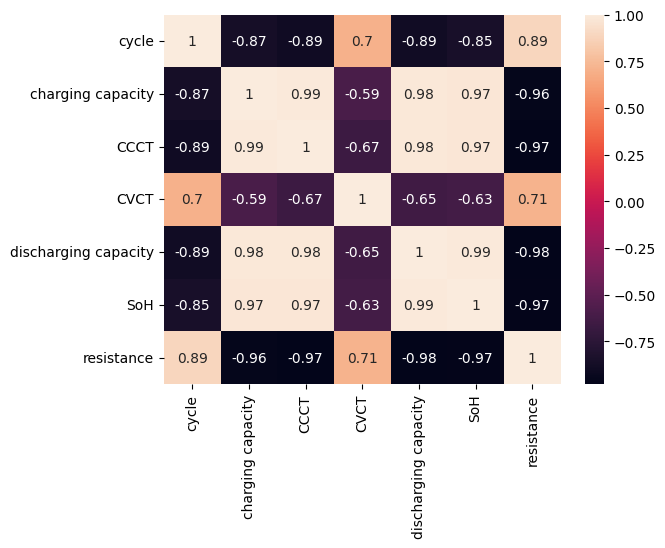

In [7]:
import seaborn as sns
sns.heatmap(df.corr(),annot=True)

In [8]:
df.fillna(method='ffill', inplace=True)
df1.fillna(method='ffill', inplace=True)
df2.fillna(method='ffill', inplace=True)

In [9]:
X = df['discharging capacity']
X1 = df1['discharging capacity']
X2 = df2['discharging capacity']


In [10]:
X

0      1.137444
1      1.126385
2      1.126160
3      1.125966
4      1.118508
         ...   
931    0.311687
932    0.302522
933    0.302530
934    0.302530
935    0.293367
Name: discharging capacity, Length: 936, dtype: float64

In [11]:
X1

0      1.143918
1      1.133807
2      1.133413
3      1.132829
4      1.127033
         ...   
971    0.155889
972    0.155896
973    0.165061
974    0.155890
975    0.165059
Name: discharging capacity, Length: 976, dtype: float64

In [12]:
idx = drop_outlier_sw(X,20)
idx1 = drop_outlier_sw(X1,20)
idx2 = drop_outlier_sw(X2,20)


x1 = X.iloc[idx]
x2 = X1.iloc[idx1]
x3 = X2.iloc[idx2]

In [13]:
x1

1      1.126385
2      1.126160
3      1.125966
4      1.118508
5      1.117210
         ...   
916    0.247524
917    0.357558
918    0.357541
919    0.348375
920    0.339218
Name: discharging capacity, Length: 873, dtype: float64

In [14]:
x2

1      1.133807
2      1.133413
3      1.132829
4      1.127033
5      1.126712
         ...   
955    0.174237
956    0.165067
957    0.165063
958    0.165059
960    0.165073
Name: discharging capacity, Length: 916, dtype: float64

X1.to_csv('X1.csv')
X2.to_csv('X2.csv')
X3.to_csv('X3.csv')

In [15]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler()

In [16]:
X1 = pd.DataFrame(x1)
X1 = ss.fit_transform(X1)
X1 = pd.DataFrame(X1)

X2 = pd.DataFrame(x2)
X2 = ss.fit_transform(X2)
X2 = pd.DataFrame(X2)

X3 = pd.DataFrame(x3)
X3 = ss.fit_transform(X3)
X3 = pd.DataFrame(X3)

X1 = X1[:832]
X2 = X2[:832]
X3 = X3[:832]

In [17]:
X1 = np.array(X1)
X2 = np.array(X2)
X3 = np.array(X3)

In [18]:
X1

array([[1.00000000e+00],
       [9.99744339e-01],
       [9.99523476e-01],
       [9.91037464e-01],
       [9.89560994e-01],
       [9.85628034e-01],
       [9.68633978e-01],
       [9.65632572e-01],
       [9.58453737e-01],
       [9.55849417e-01],
       [9.64002699e-01],
       [9.64936171e-01],
       [9.64782144e-01],
       [9.64543544e-01],
       [9.64066601e-01],
       [9.63657920e-01],
       [9.63202021e-01],
       [9.62538902e-01],
       [9.61710327e-01],
       [9.57296043e-01],
       [9.56758682e-01],
       [9.56318964e-01],
       [9.55902580e-01],
       [9.55452600e-01],
       [9.54959008e-01],
       [9.54501527e-01],
       [9.43195015e-01],
       [9.33888059e-01],
       [9.26594193e-01],
       [9.24977241e-01],
       [9.23407478e-01],
       [9.34059087e-01],
       [9.35575760e-01],
       [9.25883848e-01],
       [9.16277209e-01],
       [9.14790222e-01],
       [9.13984125e-01],
       [9.12826382e-01],
       [9.23515771e-01],
       [9.24984435e-01],


In [19]:
X1=X1.flatten()
X2=X2.flatten()
X3=X3.flatten()

In [20]:
len(X3)

989

In [21]:
X1 = pd.DataFrame(X1[:832])
X2 = pd.DataFrame(X2[:864])
X3 = pd.DataFrame(X3[:928])



In [22]:
index_x1 = np.arange(0,len(X1))
index_x2 = np.arange(0,len(X2))
index_x3 = np.arange(0,len(X3))

In [23]:
index_x1 = pd.DataFrame(index_x1)
index_x2 = pd.DataFrame(index_x2)
index_x3 = pd.DataFrame(index_x3)

In [24]:
X_1_ = pd.concat([index_x1,X1],axis=1,ignore_index=True)
X_2_ = pd.concat([index_x2,X2],axis=1,ignore_index=True)
X_3_ = pd.concat([index_x3,X3],axis=1,ignore_index=True)

In [25]:
x_1 = pd.DataFrame(X_1_)
x_2 = pd.DataFrame(X_2_)
x_3 = pd.DataFrame(X_3_)

In [26]:
x_2

,0,1
0,0,1.000000
1,1,0.999594
2,2,0.998990
3,3,0.993008
4,4,0.992676
...,...,...
859,859,0.151458
860,860,0.151451
861,861,0.151444
862,862,0.160922


In [27]:
x_2[0]

0        0
1        1
2        2
3        3
4        4
      ... 
859    859
860    860
861    861
862    862
863    863
Name: 0, Length: 864, dtype: int64

In [28]:
yyy = np.arange(0,len(X1))
yyy_1 = np.arange(0,len(X2))
yyy_2 = np.arange(0,len(X3))

In [29]:
import numpy as np
import math
from scipy.optimize import curve_fit

def my_func(x, a, b, c, d):
    return a*np.exp(b*x)+c*np.exp(d*x)

popt, pcov = curve_fit(my_func, yyy,X1[0],p0= np.array([1.1, -5e-5, -1.5e-3, .006]),bounds = ((1, -1e-3, -2e-2, .001), (1.2, -2e-5, -1e-3, .01)))
popt1, pcov1 = curve_fit(my_func, yyy_1,X2[0], p0= np.array([1.1, -5e-5, -1.5e-3, .006]),bounds = ((1, -1e-3, -2e-2, .001), (1.2, -2e-5, -1e-3, .01)))
popt2, pcov2 = curve_fit(my_func, yyy_2,X3[0], p0= np.array([1.1, -5e-5, -1.5e-3, .006]),bounds = ((1, -1e-3, -2e-2, .001), (1.2, -2e-5, -1e-3, .01)))



##x_hat, _ = curve_fit(degradation_mdl,xdata=t_data, ydata=y_data, p0=x0, bounds=bounds)


##x0 = np.array([1.1, -5e-5, -1.5e-3, .006])    
##bounds = ((1, -1e-3, -2e-2, .001), (1.2, -2e-5, -1e-3, .01))



In [30]:
a,b,c,d= popt
popt

array([ 1.00000000e+00, -4.85220740e-04, -1.00000000e-03,  7.66522897e-03])

In [31]:
a1,b1,c1,d1 = popt1
popt1

array([ 1.00000000e+00, -3.90334201e-04, -4.54808956e-03,  5.70736503e-03])

In [32]:
a2,b2,c2,d2 = popt2
popt2

array([ 1.00000000e+00, -4.44382730e-04, -1.00000000e-03,  6.74705531e-03])

In [33]:
yyy_curve_fit = []

for x in yyy:
    yyy_curve_fit.append(a*np.exp(b*x)+c*np.exp(d*x))

yyy_curve_fit1 = []

for x in yyy_1:
    yyy_curve_fit1.append(a1*np.exp(b1*x)+c1*np.exp(d1*x))
    
yyy_curve_fit2 = []

for x in yyy_2:
    yyy_curve_fit2.append(a2*np.exp(b2*x)+c2*np.exp(d2*x))

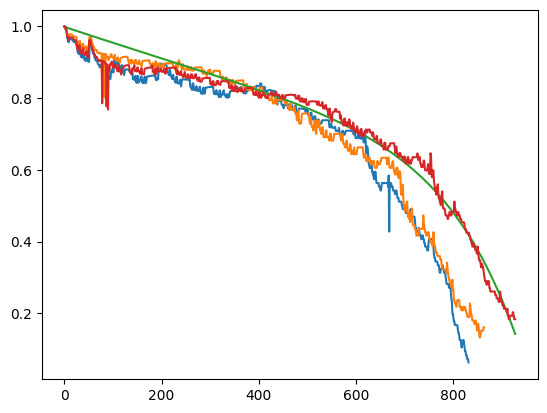

In [34]:
plt.plot(yyy,X1[0])

plt.plot(yyy_1,X2[0])

plt.plot(yyy_2,yyy_curve_fit2)
plt.plot(yyy_2,X3[0])

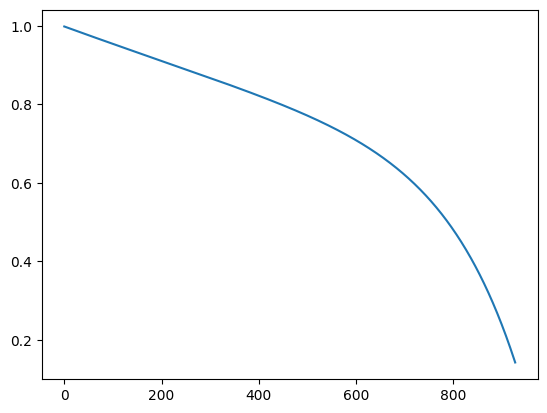

In [35]:
plt.plot(yyy_2,yyy_curve_fit2)


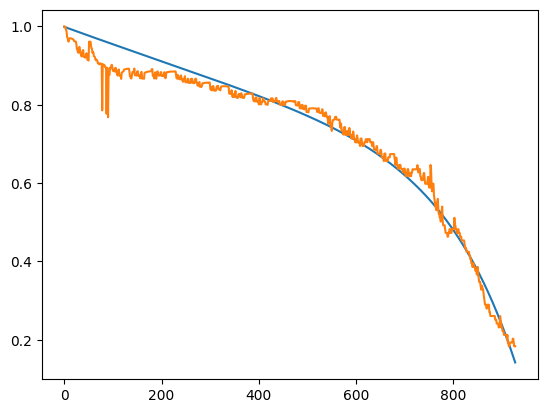

In [36]:
plt.plot(yyy_2,yyy_curve_fit2)
plt.plot(yyy_2,X3[0])

In [37]:
ax = (a+a1+a2)/3
bx = (b+b1+b2)/3
cx = (c+c1+c2)/3

In [38]:
yyy_curve_fit3 = []
for x in yyy_2:
    yyy_curve_fit3.append(a*np.exp(b*x)+c*np.exp(d*x))

[]

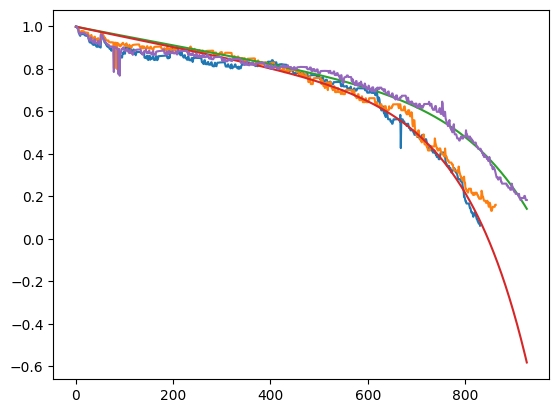

In [39]:
plt.plot(yyy,X1[0])

plt.plot(yyy_1,X2[0])

plt.plot(yyy_2,yyy_curve_fit2)

plt.plot(yyy_2,yyy_curve_fit3)

plt.plot(yyy_2,X3[0])

plt.plot()

In [40]:
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)):
		# find the end of this pattern
        end_ix = i + n_features
		# check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
		# gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_input = 32

In [41]:
X1, y1 = prepare_data(X1[0], n_input)
X2, y2 = prepare_data(X2[0], n_input)
X3, y3 = prepare_data(X3[0], n_input)

In [42]:
X2.shape

(832, 32)

In [43]:
X1_ = X1.reshape((X1.shape[0], X1.shape[1], 1))
X2_ = X2.reshape((X2.shape[0], X2.shape[1], 1))
X3_ = X3.reshape((X3.shape[0], X3.shape[1], 1))

from keras.preprocessing.sequence import TimeseriesGenerator

df_rnn = df_rnn.reshape((len(df_rnn), 1))
generated_batches = TimeseriesGenerator(df_rnn, df_rnn, length=n_input, batch_size=1)

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.LSTM(32, activation='selu', input_shape=(n_input, 1),return_sequences=True))
model_rnn.add(keras.layers.LSTM(32, activation='selu', input_shape=(n_input, 1),return_sequences=False))
model_rnn.add(keras.layers.Dense(64, activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.0002)))
model_rnn.add(keras.layers.Dense(32, activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.0002)))
model_rnn.add(keras.layers.Dense(1))

model_rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =1e-3), loss='mse')

In [44]:
k = 0

def expo(y_true,y_pred):
    global k 
    val = y_pred - k - (a * np.exp(b) + c )
    k = y_pred
    print(val + tf.math.abs(y_true-y_pred))
    print(tf.executing_eagerly())
    return val + tf.math.abs(y_true-y_pred)

    

        

In [45]:
def function(x):
    return (a*(x**2) + b*(x)+ c)

In [46]:
def huber_fn(y_true, y_pred):

    error = y_true - y_pred
    is_small_error = tensorflow.abs(error) < 1
    squared_loss = tensorflow.square(error) / 2 
    linear_loss  = tensorflow.abs(error) - 0.5
    print(y_pred.shape)
    print(tf.executing_eagerly())
    return tf.where(is_small_error, squared_loss, linear_loss)

a = (a+a1+a2)/3
b = (b+b1+b2)/3
c = (c+c1+c2)/3

In [47]:
x_1[1][2]

0.9995234755620945

In [48]:
1 in x_1.values

True

In [49]:
from sklearn.metrics import mean_squared_error

cycle_arr = []
theoretical = []

def custom(y_true,y_pred):
    global cycle_arr
    global x_1
    for i in y_true:
        if i in x_1.values:
            cycle_arr.append(x_1[x_1[1]==i][0].iloc[0])
        if i in x_2.values:
            cycle_arr.append(x_2[x_2[1]==i][0].iloc[0])
        if i in x_3.values:
            cycle_arr.append(x_3[x_3[1]==i][0].iloc[0])
    
    if y_true[0] in x_1.values:
        for cycle in cycle_arr:
            theoretical.append([a*np.exp(b*(cycle))+c*np.exp(d*(cycle))])
        mae = tensorflow.math.abs(y_true-y_pred)
        diff = tensorflow.math.abs((y_pred) - np.array(theoretical))
        error = diff + mae
        print(tensorflow.executing_eagerly())
        cycle_arr.clear()
        theoretical.clear()
        print('x1')
        return error

    if y_true[0] in x_2.values:
        for cycle in cycle_arr:
            theoretical.append([a1*np.exp(b1*(cycle))+c1*np.exp(d1*(cycle))])
        mae = tensorflow.math.abs(y_true-y_pred)
        diff = tensorflow.math.abs((y_pred) - np.array(theoretical))
        error = diff + mae
        print(tensorflow.executing_eagerly())
        cycle_arr.clear()
        theoretical.clear()
        print('x2')
        return error

    if y_true[0] in x_3.values:
        for cycle in cycle_arr:
            theoretical.append([a2*np.exp(b2*(cycle))+c2*np.exp(d2*(cycle))])
        mae = tensorflow.math.abs(y_true-y_pred)
        diff = tensorflow.math.abs((y_pred) - np.array(theoretical))
        error = diff + mae
        print(tensorflow.executing_eagerly())
        cycle_arr.clear()
        theoretical.clear()
        print('x3')
        return error


In [50]:
x_2

,0,1
0,0,1.000000
1,1,0.999594
2,2,0.998990
3,3,0.993008
4,4,0.992676
...,...,...
859,859,0.151458
860,860,0.151451
861,861,0.151444
862,862,0.160922


cycle_arr1 = []
theoretical1 = []

def custom1(y_true,y_pred):
    global cycle_arr1
    global x_1
    for i in y_true:
        cycle_arr1.append(x_3[x_3[1]==i][0].iloc[0])
    for cycle in cycle_arr1:
        theoretical1.append([a1*(cycle)**2+b1*(cycle)+c1])
    rmse = tf.math.abs(y_true-y_pred)
    diff = tf.math.abs((y_pred) - np.array(theoretical1))
    error = diff + rmse
    print(tf.executing_eagerly())
    cycle_arr1.clear()
    theoretical1.clear()
    return error
    

cycle_arr2 = []
theoretical2 = []

def custom2(y_true,y_pred):
    global cycle_arr2
    global x_1
    for i in y_true:
        cycle_arr2.append(x_1[x_1[1]==i][0].iloc[0])
    for cycle in cycle_arr2:
        theoretical2.append([a2*(cycle)**2+b2*(cycle)+c2])
    rmse = tf.math.abs(y_true-y_pred)
    diff = tf.math.abs((y_pred) - np.array(theoretical2))
    error = diff + rmse
    print(tf.executing_eagerly())
    cycle_arr2.clear()
    theoretical2.clear()
    return error
    

In [51]:
from keras import Sequential
from keras.layers import Dense, Masking, LSTM


from numpy.random import seed
seed(42)



model_rnn = Sequential()
model_rnn.add(LSTM(64,
                return_sequences=False))

model_rnn.add(Dense(16, activation='relu'))

model_rnn.add(Dense(1, activation='linear'))

model_rnn.compile(optimizer='adam', loss=custom, metrics=['mse', 'mae', 'mape'],run_eagerly = True)

Metal device set to: Apple M1


In [52]:
model_rnn.fit(X1_,y1, epochs=30, verbose=1)

Epoch 1/30


2023-07-20 13:41:09.389478: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


True
x1
 1/25 [>.............................] - ETA: 25s - loss: 1.3102 - mse: 0.4583 - mae: 0.6448 - mape: 93.4572True
x1
 2/25 [=>............................] - ETA: 5s - loss: 1.2934 - mse: 0.4381 - mae: 0.6367 - mape: 89.4264 True
x1
 3/25 [==>...........................] - ETA: 4s - loss: 1.2501 - mse: 0.4082 - mae: 0.6165 - mape: 85.3270True
x1
 4/25 [===>..........................] - ETA: 4s - loss: 1.1951 - mse: 0.3763 - mae: 0.5893 - mape: 81.5044True
x1
 5/25 [=====>........................] - ETA: 4s - loss: 1.1481 - mse: 0.3483 - mae: 0.5659 - mape: 78.0786True
x1
 6/25 [======>.......................] - ETA: 3s - loss: 1.1076 - mse: 0.3250 - mae: 0.5460 - mape: 74.5806True
x1
 7/25 [=======>......................] - ETA: 3s - loss: 1.0481 - mse: 0.2972 - mae: 0.5175 - mape: 70.8538True
x1
 8/25 [========>.....................] - ETA: 3s - loss: 0.9860 - mse: 0.2709 - mae: 0.4867 - mape: 66.6469True
x1
 9/25 [=========>....................] - ETA: 3s - loss: 0.9206 - mse:

22/25 [=========================>....] - ETA: 0s - loss: 0.0652 - mse: 0.0011 - mae: 0.0288 - mape: 5.5989True
x1
23/25 [==========================>...] - ETA: 0s - loss: 0.0648 - mse: 0.0011 - mae: 0.0285 - mape: 5.5159True
x1
24/25 [===========================>..] - ETA: 0s - loss: 0.0645 - mse: 0.0011 - mae: 0.0282 - mape: 5.4205True
x1
25/25 [==============================] - 5s 205ms/step - loss: 0.0635 - mse: 0.0010 - mae: 0.0276 - mape: 5.2785
Epoch 4/30
True
x1
 1/25 [>.............................] - ETA: 4s - loss: 0.0473 - mse: 2.1967e-04 - mae: 0.0098 - mape: 1.9567True
x1
 2/25 [=>............................] - ETA: 4s - loss: 0.0470 - mse: 3.4629e-04 - mae: 0.0140 - mape: 3.0782True
x1
 3/25 [==>...........................] - ETA: 4s - loss: 0.0484 - mse: 4.6904e-04 - mae: 0.0172 - mape: 3.2087True
x1
 4/25 [===>..........................] - ETA: 4s - loss: 0.0470 - mse: 4.7171e-04 - mae: 0.0176 - mape: 3.2738True
x1
 5/25 [=====>........................] - ETA: 3s - los

16/25 [==================>...........] - ETA: 2s - loss: 0.0385 - mse: 2.2416e-04 - mae: 0.0110 - mape: 2.3000True
x1
17/25 [===================>..........] - ETA: 2s - loss: 0.0384 - mse: 2.2235e-04 - mae: 0.0110 - mape: 2.2515True
x1
18/25 [====================>.........] - ETA: 1s - loss: 0.0387 - mse: 2.2457e-04 - mae: 0.0111 - mape: 2.2724True
x1
19/25 [=====================>........] - ETA: 1s - loss: 0.0387 - mse: 2.2271e-04 - mae: 0.0111 - mape: 2.2581True
x1
20/25 [=======================>......] - ETA: 1s - loss: 0.0386 - mse: 2.1835e-04 - mae: 0.0110 - mape: 2.2163True
x1
21/25 [========================>.....] - ETA: 1s - loss: 0.0386 - mse: 2.1524e-04 - mae: 0.0110 - mape: 2.2683True
x1
22/25 [=========================>....] - ETA: 0s - loss: 0.0385 - mse: 2.1625e-04 - mae: 0.0110 - mape: 2.2629True
x1
23/25 [==========================>...] - ETA: 0s - loss: 0.0387 - mse: 2.1849e-04 - mae: 0.0111 - mape: 2.2917True
x1
24/25 [===========================>..] - ETA: 0s - loss:

10/25 [===========>..................] - ETA: 2s - loss: 0.0392 - mse: 2.3392e-04 - mae: 0.0110 - mape: 2.2276True
x1
11/25 [============>.................] - ETA: 2s - loss: 0.0392 - mse: 2.3059e-04 - mae: 0.0111 - mape: 2.2131True
x1
12/25 [=============>................] - ETA: 2s - loss: 0.0388 - mse: 2.3441e-04 - mae: 0.0113 - mape: 2.2400True
x1
13/25 [==============>...............] - ETA: 2s - loss: 0.0383 - mse: 2.2398e-04 - mae: 0.0110 - mape: 2.2097True
x1
14/25 [===============>..............] - ETA: 1s - loss: 0.0382 - mse: 2.2080e-04 - mae: 0.0110 - mape: 2.1951True
x1
15/25 [=================>............] - ETA: 1s - loss: 0.0380 - mse: 2.1337e-04 - mae: 0.0108 - mape: 2.1316True
x1
16/25 [==================>...........] - ETA: 1s - loss: 0.0381 - mse: 2.0812e-04 - mae: 0.0107 - mape: 2.1327True
x1
17/25 [===================>..........] - ETA: 1s - loss: 0.0385 - mse: 2.0762e-04 - mae: 0.0106 - mape: 2.0903True
x1
18/25 [====================>.........] - ETA: 1s - loss:

 4/25 [===>..........................] - ETA: 4s - loss: 0.0391 - mse: 1.7503e-04 - mae: 0.0106 - mape: 1.7557True
x1
 5/25 [=====>........................] - ETA: 4s - loss: 0.0393 - mse: 1.8328e-04 - mae: 0.0108 - mape: 1.8106True
x1
 6/25 [======>.......................] - ETA: 3s - loss: 0.0392 - mse: 1.8256e-04 - mae: 0.0107 - mape: 1.8430True
x1
 7/25 [=======>......................] - ETA: 3s - loss: 0.0390 - mse: 1.8100e-04 - mae: 0.0106 - mape: 1.8597True
x1
 8/25 [========>.....................] - ETA: 3s - loss: 0.0391 - mse: 1.7453e-04 - mae: 0.0103 - mape: 1.8157True
x1
 9/25 [=========>....................] - ETA: 3s - loss: 0.0384 - mse: 1.6636e-04 - mae: 0.0100 - mape: 1.7220True
x1
10/25 [===========>..................] - ETA: 3s - loss: 0.0388 - mse: 1.6940e-04 - mae: 0.0101 - mape: 1.6990True
x1
11/25 [============>.................] - ETA: 2s - loss: 0.0389 - mse: 1.6729e-04 - mae: 0.0100 - mape: 1.7555True
x1
12/25 [=============>................] - ETA: 2s - loss:

23/25 [==========================>...] - ETA: 0s - loss: 0.0407 - mse: 2.6053e-04 - mae: 0.0124 - mape: 2.2584True
x1
24/25 [===========================>..] - ETA: 0s - loss: 0.0407 - mse: 2.5888e-04 - mae: 0.0123 - mape: 2.2596True
x1
25/25 [==============================] - 6s 223ms/step - loss: 0.0406 - mse: 2.5344e-04 - mae: 0.0122 - mape: 2.2155
Epoch 15/30
True
x1
 1/25 [>.............................] - ETA: 5s - loss: 0.0395 - mse: 2.2890e-04 - mae: 0.0114 - mape: 1.7601True
x1
 2/25 [=>............................] - ETA: 4s - loss: 0.0445 - mse: 4.3787e-04 - mae: 0.0166 - mape: 2.4048True
x1
 3/25 [==>...........................] - ETA: 4s - loss: 0.0478 - mse: 5.7682e-04 - mae: 0.0200 - mape: 4.3439True
x1
 4/25 [===>..........................] - ETA: 4s - loss: 0.0464 - mse: 5.1407e-04 - mae: 0.0188 - mape: 4.1176True
x1
 5/25 [=====>........................] - ETA: 3s - loss: 0.0446 - mse: 4.5022e-04 - mae: 0.0173 - mape: 3.8077True
x1
 6/25 [======>.......................

17/25 [===================>..........] - ETA: 1s - loss: 0.0409 - mse: 2.4873e-04 - mae: 0.0119 - mape: 2.2520True
x1
18/25 [====================>.........] - ETA: 1s - loss: 0.0414 - mse: 2.6037e-04 - mae: 0.0123 - mape: 2.2798True
x1
19/25 [=====================>........] - ETA: 1s - loss: 0.0413 - mse: 2.6411e-04 - mae: 0.0124 - mape: 2.3077True
x1
20/25 [=======================>......] - ETA: 0s - loss: 0.0415 - mse: 2.6208e-04 - mae: 0.0124 - mape: 2.2852True
x1
21/25 [========================>.....] - ETA: 0s - loss: 0.0411 - mse: 2.5850e-04 - mae: 0.0124 - mape: 2.2584True
x1
22/25 [=========================>....] - ETA: 0s - loss: 0.0410 - mse: 2.5433e-04 - mae: 0.0123 - mape: 2.2446True
x1
23/25 [==========================>...] - ETA: 0s - loss: 0.0407 - mse: 2.4902e-04 - mae: 0.0121 - mape: 2.2089True
x1
24/25 [===========================>..] - ETA: 0s - loss: 0.0404 - mse: 2.4699e-04 - mae: 0.0121 - mape: 2.1988True
x1
25/25 [==============================] - 5s 193ms/step -

11/25 [============>.................] - ETA: 2s - loss: 0.0381 - mse: 1.7393e-04 - mae: 0.0104 - mape: 1.8929True
x1
12/25 [=============>................] - ETA: 2s - loss: 0.0380 - mse: 1.7012e-04 - mae: 0.0102 - mape: 1.8405True
x1
13/25 [==============>...............] - ETA: 2s - loss: 0.0378 - mse: 1.6720e-04 - mae: 0.0101 - mape: 1.8644True
x1
14/25 [===============>..............] - ETA: 2s - loss: 0.0379 - mse: 1.6788e-04 - mae: 0.0101 - mape: 1.8542True
x1
15/25 [=================>............] - ETA: 1s - loss: 0.0381 - mse: 1.7288e-04 - mae: 0.0102 - mape: 1.9341True
x1
16/25 [==================>...........] - ETA: 1s - loss: 0.0386 - mse: 1.7474e-04 - mae: 0.0102 - mape: 1.9065True
x1
17/25 [===================>..........] - ETA: 1s - loss: 0.0387 - mse: 1.8032e-04 - mae: 0.0104 - mape: 1.9595True
x1
18/25 [====================>.........] - ETA: 1s - loss: 0.0387 - mse: 1.8124e-04 - mae: 0.0104 - mape: 2.0238True
x1
19/25 [=====================>........] - ETA: 1s - loss:

 5/25 [=====>........................] - ETA: 3s - loss: 0.0405 - mse: 1.6579e-04 - mae: 0.0100 - mape: 1.5943True
x1
 6/25 [======>.......................] - ETA: 3s - loss: 0.0390 - mse: 1.6712e-04 - mae: 0.0102 - mape: 1.6136True
x1
 7/25 [=======>......................] - ETA: 3s - loss: 0.0396 - mse: 1.9368e-04 - mae: 0.0109 - mape: 1.8735True
x1
 8/25 [========>.....................] - ETA: 3s - loss: 0.0396 - mse: 1.9492e-04 - mae: 0.0110 - mape: 1.9504True
x1
 9/25 [=========>....................] - ETA: 3s - loss: 0.0397 - mse: 1.8857e-04 - mae: 0.0108 - mape: 1.9637True
x1
10/25 [===========>..................] - ETA: 2s - loss: 0.0398 - mse: 2.2241e-04 - mae: 0.0109 - mape: 1.9642True
x1
11/25 [============>.................] - ETA: 2s - loss: 0.0398 - mse: 2.1942e-04 - mae: 0.0109 - mape: 1.9631True
x1
12/25 [=============>................] - ETA: 2s - loss: 0.0405 - mse: 2.2760e-04 - mae: 0.0113 - mape: 1.9811True
x1
13/25 [==============>...............] - ETA: 2s - loss:

24/25 [===========================>..] - ETA: 0s - loss: 0.0373 - mse: 1.7528e-04 - mae: 0.0096 - mape: 1.7816True
x1
25/25 [==============================] - 5s 209ms/step - loss: 0.0377 - mse: 1.7774e-04 - mae: 0.0097 - mape: 1.7805
Epoch 26/30
True
x1
 1/25 [>.............................] - ETA: 5s - loss: 0.0370 - mse: 7.1853e-05 - mae: 0.0064 - mape: 1.0220True
x1
 2/25 [=>............................] - ETA: 4s - loss: 0.0384 - mse: 1.4492e-04 - mae: 0.0093 - mape: 1.3888True
x1
 3/25 [==>...........................] - ETA: 4s - loss: 0.0398 - mse: 1.8959e-04 - mae: 0.0105 - mape: 1.5382True
x1
 4/25 [===>..........................] - ETA: 4s - loss: 0.0399 - mse: 1.7435e-04 - mae: 0.0101 - mape: 1.7405True
x1
 5/25 [=====>........................] - ETA: 4s - loss: 0.0396 - mse: 1.8461e-04 - mae: 0.0106 - mape: 2.0304True
x1
 6/25 [======>.......................] - ETA: 3s - loss: 0.0402 - mse: 1.7752e-04 - mae: 0.0103 - mape: 1.8830True
x1
 7/25 [=======>......................

18/25 [====================>.........] - ETA: 1s - loss: 0.0381 - mse: 1.9289e-04 - mae: 0.0101 - mape: 1.7984True
x1
19/25 [=====================>........] - ETA: 1s - loss: 0.0381 - mse: 1.9352e-04 - mae: 0.0101 - mape: 1.8060True
x1
20/25 [=======================>......] - ETA: 1s - loss: 0.0378 - mse: 1.8731e-04 - mae: 0.0099 - mape: 1.7708True
x1
21/25 [========================>.....] - ETA: 0s - loss: 0.0376 - mse: 1.8306e-04 - mae: 0.0098 - mape: 1.7493True
x1
22/25 [=========================>....] - ETA: 0s - loss: 0.0375 - mse: 1.7891e-04 - mae: 0.0097 - mape: 1.7385True
x1
23/25 [==========================>...] - ETA: 0s - loss: 0.0373 - mse: 1.7577e-04 - mae: 0.0096 - mape: 1.7414True
x1
24/25 [===========================>..] - ETA: 0s - loss: 0.0374 - mse: 1.7470e-04 - mae: 0.0096 - mape: 1.7411True
x1
25/25 [==============================] - 5s 212ms/step - loss: 0.0373 - mse: 1.7319e-04 - mae: 0.0096 - mape: 1.7316
Epoch 29/30
True
x1
 1/25 [>.............................

In [53]:
model_rnn.fit(X2_,y2, epochs=30, verbose=1)

Epoch 1/30
True
x2
 1/26 [>.............................] - ETA: 6s - loss: 0.0310 - mse: 2.5790e-04 - mae: 0.0122 - mape: 2.2405True
x2
 2/26 [=>............................] - ETA: 5s - loss: 0.0321 - mse: 2.2774e-04 - mae: 0.0120 - mape: 2.2442True
x2
 3/26 [==>...........................] - ETA: 5s - loss: 0.0287 - mse: 2.0489e-04 - mae: 0.0112 - mape: 1.9612True
x2
 4/26 [===>..........................] - ETA: 5s - loss: 0.0280 - mse: 1.8788e-04 - mae: 0.0108 - mape: 1.8747True
x2
 5/26 [====>.........................] - ETA: 5s - loss: 0.0280 - mse: 1.9234e-04 - mae: 0.0110 - mape: 1.9470True
x2
 6/26 [=====>........................] - ETA: 5s - loss: 0.0294 - mse: 1.9851e-04 - mae: 0.0114 - mape: 1.9481True
x2
 7/26 [=======>......................] - ETA: 4s - loss: 0.0296 - mse: 2.0079e-04 - mae: 0.0116 - mape: 2.0757True
x2
 8/26 [========>.....................] - ETA: 4s - loss: 0.0302 - mse: 2.1766e-04 - mae: 0.0120 - mape: 2.0805True
x2
 9/26 [=========>....................

18/26 [===================>..........] - ETA: 1s - loss: 0.0274 - mse: 2.1255e-04 - mae: 0.0106 - mape: 1.9317True
x2
19/26 [====================>.........] - ETA: 1s - loss: 0.0275 - mse: 2.1103e-04 - mae: 0.0106 - mape: 1.9270True
x2
20/26 [======================>.......] - ETA: 3:44 - loss: 0.0274 - mse: 2.0714e-04 - mae: 0.0106 - mape: 1.9141True
x2
21/26 [=======================>......] - ETA: 2:58 - loss: 0.0274 - mse: 2.0788e-04 - mae: 0.0107 - mape: 1.9125True
x2
22/26 [========================>.....] - ETA: 2:15 - loss: 0.0274 - mse: 2.0331e-04 - mae: 0.0106 - mape: 1.8850True
x2
23/26 [=========================>....] - ETA: 1:37 - loss: 0.0274 - mse: 2.1569e-04 - mae: 0.0107 - mape: 1.9080True
x2
24/26 [==========================>...] - ETA: 1:02 - loss: 0.0275 - mse: 2.1051e-04 - mae: 0.0105 - mape: 1.8847True
x2
25/26 [===========================>..] - ETA: 29s - loss: 0.0272 - mse: 2.0574e-04 - mae: 0.0104 - mape: 1.8528 True
x2
26/26 [==============================] - 715

 8/26 [========>.....................] - ETA: 4s - loss: 0.0300 - mse: 2.8210e-04 - mae: 0.0114 - mape: 1.9127True
x2
 9/26 [=========>....................] - ETA: 4s - loss: 0.0300 - mse: 2.8837e-04 - mae: 0.0118 - mape: 1.9820True
x2
10/26 [==========>...................] - ETA: 4s - loss: 0.0302 - mse: 2.9918e-04 - mae: 0.0124 - mape: 2.0914True
x2
11/26 [===========>..................] - ETA: 3s - loss: 0.0298 - mse: 2.8417e-04 - mae: 0.0122 - mape: 2.0812True
x2
12/26 [============>.................] - ETA: 3s - loss: 0.0299 - mse: 2.7099e-04 - mae: 0.0119 - mape: 2.0234True
x2
13/26 [==============>...............] - ETA: 3s - loss: 0.0300 - mse: 2.8223e-04 - mae: 0.0119 - mape: 2.0115True
x2
14/26 [===============>..............] - ETA: 3s - loss: 0.0301 - mse: 2.7638e-04 - mae: 0.0119 - mape: 2.0154True
x2
15/26 [================>.............] - ETA: 3s - loss: 0.0303 - mse: 2.8030e-04 - mae: 0.0122 - mape: 2.0715True
x2
16/26 [=================>............] - ETA: 2s - loss:

25/26 [===========================>..] - ETA: 0s - loss: 0.0283 - mse: 2.1128e-04 - mae: 0.0108 - mape: 1.9254True
x2
26/26 [==============================] - 5s 209ms/step - loss: 0.0285 - mse: 2.1129e-04 - mae: 0.0108 - mape: 1.9190
Epoch 9/30
True
x2
 1/26 [>.............................] - ETA: 3s - loss: 0.0222 - mse: 8.8280e-05 - mae: 0.0076 - mape: 1.1883True
x2
 2/26 [=>............................] - ETA: 3s - loss: 0.0278 - mse: 3.7189e-04 - mae: 0.0118 - mape: 1.8255True
x2
 3/26 [==>...........................] - ETA: 3s - loss: 0.0276 - mse: 3.0218e-04 - mae: 0.0114 - mape: 1.8681True
x2
 4/26 [===>..........................] - ETA: 3s - loss: 0.0295 - mse: 2.9313e-04 - mae: 0.0117 - mape: 1.8406True
x2
 5/26 [====>.........................] - ETA: 3s - loss: 0.0284 - mse: 2.5855e-04 - mae: 0.0111 - mape: 1.7577True
x2
 6/26 [=====>........................] - ETA: 3s - loss: 0.0278 - mse: 2.4676e-04 - mae: 0.0108 - mape: 1.6896True
x2
 7/26 [=======>......................]

16/26 [=================>............] - ETA: 1s - loss: 0.0301 - mse: 2.9935e-04 - mae: 0.0126 - mape: 2.1623True
x2
17/26 [==================>...........] - ETA: 1s - loss: 0.0299 - mse: 2.9239e-04 - mae: 0.0124 - mape: 2.1221True
x2
18/26 [===================>..........] - ETA: 1s - loss: 0.0297 - mse: 2.8464e-04 - mae: 0.0123 - mape: 2.1146True
x2
19/26 [====================>.........] - ETA: 1s - loss: 0.0298 - mse: 2.7840e-04 - mae: 0.0122 - mape: 2.0889True
x2
20/26 [======================>.......] - ETA: 1s - loss: 0.0299 - mse: 2.7709e-04 - mae: 0.0123 - mape: 2.1076True
x2
21/26 [=======================>......] - ETA: 0s - loss: 0.0296 - mse: 2.7076e-04 - mae: 0.0122 - mape: 2.0828True
x2
22/26 [========================>.....] - ETA: 0s - loss: 0.0295 - mse: 2.6742e-04 - mae: 0.0121 - mape: 2.0765True
x2
23/26 [=========================>....] - ETA: 0s - loss: 0.0298 - mse: 2.6338e-04 - mae: 0.0121 - mape: 2.0845True
x2
24/26 [==========================>...] - ETA: 0s - loss:

 7/26 [=======>......................] - ETA: 3s - loss: 0.0307 - mse: 2.8158e-04 - mae: 0.0126 - mape: 2.1137True
x2
 8/26 [========>.....................] - ETA: 3s - loss: 0.0302 - mse: 2.5682e-04 - mae: 0.0121 - mape: 2.0286True
x2
 9/26 [=========>....................] - ETA: 3s - loss: 0.0304 - mse: 2.4720e-04 - mae: 0.0119 - mape: 2.0025True
x2
10/26 [==========>...................] - ETA: 3s - loss: 0.0303 - mse: 2.3773e-04 - mae: 0.0118 - mape: 2.0014True
x2
11/26 [===========>..................] - ETA: 2s - loss: 0.0303 - mse: 2.3849e-04 - mae: 0.0118 - mape: 2.0016True
x2
12/26 [============>.................] - ETA: 2s - loss: 0.0299 - mse: 2.3740e-04 - mae: 0.0118 - mape: 2.0367True
x2
13/26 [==============>...............] - ETA: 2s - loss: 0.0294 - mse: 2.2916e-04 - mae: 0.0116 - mape: 2.0059True
x2
14/26 [===============>..............] - ETA: 2s - loss: 0.0291 - mse: 2.2229e-04 - mae: 0.0114 - mape: 1.9838True
x2
15/26 [================>.............] - ETA: 2s - loss:

24/26 [==========================>...] - ETA: 0s - loss: 0.0285 - mse: 2.3007e-04 - mae: 0.0111 - mape: 1.9603True
x2
25/26 [===========================>..] - ETA: 0s - loss: 0.0282 - mse: 2.2540e-04 - mae: 0.0110 - mape: 1.9373True
x2
26/26 [==============================] - 5s 192ms/step - loss: 0.0280 - mse: 2.2210e-04 - mae: 0.0109 - mape: 1.9385
Epoch 17/30
True
x2
 1/26 [>.............................] - ETA: 4s - loss: 0.0218 - mse: 9.6679e-05 - mae: 0.0083 - mape: 1.5107True
x2
 2/26 [=>............................] - ETA: 4s - loss: 0.0268 - mse: 1.3932e-04 - mae: 0.0095 - mape: 1.6240True
x2
 3/26 [==>...........................] - ETA: 4s - loss: 0.0274 - mse: 1.5207e-04 - mae: 0.0101 - mape: 1.7203True
x2
 4/26 [===>..........................] - ETA: 4s - loss: 0.0286 - mse: 1.5356e-04 - mae: 0.0102 - mape: 1.7901True
x2
 5/26 [====>.........................] - ETA: 3s - loss: 0.0281 - mse: 1.5224e-04 - mae: 0.0100 - mape: 1.8717True
x2
 6/26 [=====>........................

15/26 [================>.............] - ETA: 2s - loss: 0.0277 - mse: 2.4533e-04 - mae: 0.0107 - mape: 2.0214True
x2
16/26 [=================>............] - ETA: 2s - loss: 0.0274 - mse: 2.3561e-04 - mae: 0.0105 - mape: 1.9879True
x2
17/26 [==================>...........] - ETA: 1s - loss: 0.0273 - mse: 2.2631e-04 - mae: 0.0103 - mape: 1.9559True
x2
18/26 [===================>..........] - ETA: 1s - loss: 0.0273 - mse: 2.2477e-04 - mae: 0.0104 - mape: 1.9519True
x2
19/26 [====================>.........] - ETA: 1s - loss: 0.0270 - mse: 2.1874e-04 - mae: 0.0103 - mape: 1.9236True
x2
20/26 [======================>.......] - ETA: 1s - loss: 0.0270 - mse: 2.1377e-04 - mae: 0.0102 - mape: 1.9009True
x2
21/26 [=======================>......] - ETA: 0s - loss: 0.0270 - mse: 2.1158e-04 - mae: 0.0102 - mape: 1.9003True
x2
22/26 [========================>.....] - ETA: 0s - loss: 0.0271 - mse: 2.0964e-04 - mae: 0.0102 - mape: 1.9024True
x2
23/26 [=========================>....] - ETA: 0s - loss:

 6/26 [=====>........................] - ETA: 2s - loss: 0.0303 - mse: 3.4447e-04 - mae: 0.0127 - mape: 2.2031True
x2
 7/26 [=======>......................] - ETA: 2s - loss: 0.0307 - mse: 3.3887e-04 - mae: 0.0131 - mape: 2.2123True
x2
 8/26 [========>.....................] - ETA: 2s - loss: 0.0308 - mse: 3.2643e-04 - mae: 0.0130 - mape: 2.2123True
x2
 9/26 [=========>....................] - ETA: 2s - loss: 0.0303 - mse: 3.0356e-04 - mae: 0.0125 - mape: 2.1067True
x2
10/26 [==========>...................] - ETA: 2s - loss: 0.0291 - mse: 2.8320e-04 - mae: 0.0120 - mape: 2.0032True
x2
11/26 [===========>..................] - ETA: 1s - loss: 0.0290 - mse: 3.0043e-04 - mae: 0.0119 - mape: 2.0095True
x2
12/26 [============>.................] - ETA: 1s - loss: 0.0285 - mse: 2.8509e-04 - mae: 0.0116 - mape: 1.9615True
x2
13/26 [==============>...............] - ETA: 1s - loss: 0.0284 - mse: 2.7295e-04 - mae: 0.0115 - mape: 1.9901True
x2
14/26 [===============>..............] - ETA: 1s - loss:

23/26 [=========================>....] - ETA: 0s - loss: 0.0267 - mse: 2.0074e-04 - mae: 0.0099 - mape: 1.8636True
x2
24/26 [==========================>...] - ETA: 0s - loss: 0.0266 - mse: 1.9721e-04 - mae: 0.0098 - mape: 1.8534True
x2
25/26 [===========================>..] - ETA: 0s - loss: 0.0265 - mse: 1.9596e-04 - mae: 0.0099 - mape: 1.8547True
x2
26/26 [==============================] - 3s 128ms/step - loss: 0.0265 - mse: 1.9235e-04 - mae: 0.0098 - mape: 1.8364
Epoch 25/30
True
x2
 1/26 [>.............................] - ETA: 3s - loss: 0.0193 - mse: 1.0797e-04 - mae: 0.0085 - mape: 1.4952True
x2
 2/26 [=>............................] - ETA: 3s - loss: 0.0222 - mse: 1.2530e-04 - mae: 0.0086 - mape: 1.5647True
x2
 3/26 [==>...........................] - ETA: 2s - loss: 0.0234 - mse: 1.1864e-04 - mae: 0.0084 - mape: 1.5721True
x2
 4/26 [===>..........................] - ETA: 2s - loss: 0.0236 - mse: 1.1142e-04 - mae: 0.0083 - mape: 1.5872True
x2
 5/26 [====>.........................

14/26 [===============>..............] - ETA: 1s - loss: 0.0275 - mse: 2.3182e-04 - mae: 0.0105 - mape: 1.8640True
x2
15/26 [================>.............] - ETA: 1s - loss: 0.0282 - mse: 2.7243e-04 - mae: 0.0112 - mape: 1.9503True
x2
16/26 [=================>............] - ETA: 1s - loss: 0.0279 - mse: 2.6523e-04 - mae: 0.0112 - mape: 1.9468True
x2
17/26 [==================>...........] - ETA: 1s - loss: 0.0285 - mse: 2.6613e-04 - mae: 0.0114 - mape: 1.9610True
x2
18/26 [===================>..........] - ETA: 1s - loss: 0.0286 - mse: 2.6223e-04 - mae: 0.0114 - mape: 2.0648True
x2
19/26 [====================>.........] - ETA: 0s - loss: 0.0282 - mse: 2.5147e-04 - mae: 0.0112 - mape: 2.0039True
x2
20/26 [======================>.......] - ETA: 0s - loss: 0.0285 - mse: 2.4887e-04 - mae: 0.0112 - mape: 1.9945True
x2
21/26 [=======================>......] - ETA: 0s - loss: 0.0285 - mse: 2.4433e-04 - mae: 0.0112 - mape: 1.9834True
x2
22/26 [========================>.....] - ETA: 0s - loss:

 5/26 [====>.........................] - ETA: 2s - loss: 0.0256 - mse: 2.4189e-04 - mae: 0.0099 - mape: 1.7553True
x2
 6/26 [=====>........................] - ETA: 2s - loss: 0.0261 - mse: 2.4802e-04 - mae: 0.0104 - mape: 1.8800True
x2
 7/26 [=======>......................] - ETA: 2s - loss: 0.0261 - mse: 2.3030e-04 - mae: 0.0102 - mape: 1.8720True
x2
 8/26 [========>.....................] - ETA: 2s - loss: 0.0267 - mse: 2.2094e-04 - mae: 0.0102 - mape: 1.8267True
x2
 9/26 [=========>....................] - ETA: 2s - loss: 0.0268 - mse: 2.1217e-04 - mae: 0.0100 - mape: 1.8430True
x2
10/26 [==========>...................] - ETA: 2s - loss: 0.0270 - mse: 2.4781e-04 - mae: 0.0104 - mape: 1.9326True
x2
11/26 [===========>..................] - ETA: 1s - loss: 0.0272 - mse: 2.4163e-04 - mae: 0.0106 - mape: 1.9452True
x2
12/26 [============>.................] - ETA: 1s - loss: 0.0275 - mse: 2.4089e-04 - mae: 0.0107 - mape: 1.9783True
x2
13/26 [==============>...............] - ETA: 1s - loss:

In [54]:
model_rnn.fit(X3_,y3, epochs=30, verbose=1)

Epoch 1/30
True
x3
 1/28 [>.............................] - ETA: 3s - loss: 0.0234 - mse: 7.3277e-05 - mae: 0.0058 - mape: 1.2123True
x3
 2/28 [=>............................] - ETA: 3s - loss: 0.0239 - mse: 8.2925e-05 - mae: 0.0070 - mape: 1.2235True
x3
 3/28 [==>...........................] - ETA: 3s - loss: 0.0250 - mse: 7.6207e-05 - mae: 0.0067 - mape: 1.1620True
x3
 4/28 [===>..........................] - ETA: 3s - loss: 0.0278 - mse: 1.9019e-04 - mae: 0.0078 - mape: 1.3224True
x3
 5/28 [====>.........................] - ETA: 3s - loss: 0.0290 - mse: 1.7178e-04 - mae: 0.0078 - mape: 1.2850True
x3
 6/28 [=====>........................] - ETA: 2s - loss: 0.0287 - mse: 1.5998e-04 - mae: 0.0077 - mape: 1.2541True
x3
 7/28 [======>.......................] - ETA: 2s - loss: 0.0280 - mse: 1.5198e-04 - mae: 0.0078 - mape: 1.3203True
x3
 8/28 [=======>......................] - ETA: 2s - loss: 0.0290 - mse: 1.9902e-04 - mae: 0.0083 - mape: 1.3710True
x3
 9/28 [========>.....................

14/28 [==============>...............] - ETA: 1s - loss: 0.0313 - mse: 2.4051e-04 - mae: 0.0116 - mape: 1.7410True
x3
15/28 [===============>..............] - ETA: 1s - loss: 0.0317 - mse: 2.3758e-04 - mae: 0.0116 - mape: 1.7356True
x3
16/28 [================>.............] - ETA: 1s - loss: 0.0313 - mse: 2.2646e-04 - mae: 0.0113 - mape: 1.6973True
x3
17/28 [=================>............] - ETA: 1s - loss: 0.0312 - mse: 2.2367e-04 - mae: 0.0112 - mape: 1.6743True
x3
18/28 [==================>...........] - ETA: 1s - loss: 0.0312 - mse: 2.1966e-04 - mae: 0.0111 - mape: 1.6596True
x3
19/28 [===================>..........] - ETA: 1s - loss: 0.0311 - mse: 2.1552e-04 - mae: 0.0110 - mape: 1.6523True
x3
20/28 [====================>.........] - ETA: 1s - loss: 0.0311 - mse: 2.0896e-04 - mae: 0.0109 - mape: 1.6302True
x3
21/28 [=====================>........] - ETA: 0s - loss: 0.0313 - mse: 2.0539e-04 - mae: 0.0108 - mape: 1.6192True
x3
22/28 [======================>.......] - ETA: 0s - loss:

27/28 [===========================>..] - ETA: 0s - loss: 0.0288 - mse: 1.7657e-04 - mae: 0.0095 - mape: 1.4716True
x3
28/28 [==============================] - 4s 158ms/step - loss: 0.0291 - mse: 1.9651e-04 - mae: 0.0096 - mape: 1.4994
Epoch 6/30
True
x3
 1/28 [>.............................] - ETA: 5s - loss: 0.0292 - mse: 1.4188e-04 - mae: 0.0099 - mape: 1.6152True
x3
 2/28 [=>............................] - ETA: 5s - loss: 0.0285 - mse: 1.1838e-04 - mae: 0.0089 - mape: 1.4132True
x3
 3/28 [==>...........................] - ETA: 5s - loss: 0.0288 - mse: 1.1935e-04 - mae: 0.0089 - mape: 1.3758True
x3
 4/28 [===>..........................] - ETA: 4s - loss: 0.0288 - mse: 1.2497e-04 - mae: 0.0090 - mape: 1.5481True
x3
 5/28 [====>.........................] - ETA: 4s - loss: 0.0282 - mse: 1.2572e-04 - mae: 0.0091 - mape: 1.5049True
x3
 6/28 [=====>........................] - ETA: 4s - loss: 0.0293 - mse: 1.5601e-04 - mae: 0.0099 - mape: 1.5654True
x3
 7/28 [======>.......................]

12/28 [===========>..................] - ETA: 3s - loss: 0.0271 - mse: 1.3467e-04 - mae: 0.0087 - mape: 1.3817True
x3
13/28 [============>.................] - ETA: 2s - loss: 0.0271 - mse: 1.3741e-04 - mae: 0.0088 - mape: 1.3986True
x3
14/28 [==============>...............] - ETA: 2s - loss: 0.0276 - mse: 1.7499e-04 - mae: 0.0092 - mape: 1.4516True
x3
15/28 [===============>..............] - ETA: 2s - loss: 0.0276 - mse: 1.6955e-04 - mae: 0.0092 - mape: 1.4520True
x3
16/28 [================>.............] - ETA: 2s - loss: 0.0275 - mse: 1.6596e-04 - mae: 0.0091 - mape: 1.4673True
x3
17/28 [=================>............] - ETA: 2s - loss: 0.0279 - mse: 1.9236e-04 - mae: 0.0093 - mape: 1.4771True
x3
18/28 [==================>...........] - ETA: 1s - loss: 0.0279 - mse: 1.8698e-04 - mae: 0.0091 - mape: 1.4486True
x3
19/28 [===================>..........] - ETA: 1s - loss: 0.0280 - mse: 1.8519e-04 - mae: 0.0092 - mape: 1.4628True
x3
20/28 [====================>.........] - ETA: 1s - loss:

25/28 [=========================>....] - ETA: 0s - loss: 0.0293 - mse: 2.0792e-04 - mae: 0.0105 - mape: 1.6338True
x3
26/28 [==========================>...] - ETA: 0s - loss: 0.0293 - mse: 2.0295e-04 - mae: 0.0104 - mape: 1.6107True
x3
27/28 [===========================>..] - ETA: 0s - loss: 0.0294 - mse: 2.1519e-04 - mae: 0.0104 - mape: 1.6170True
x3
28/28 [==============================] - 4s 130ms/step - loss: 0.0296 - mse: 2.1571e-04 - mae: 0.0105 - mape: 1.6309
Epoch 11/30
True
x3
 1/28 [>.............................] - ETA: 3s - loss: 0.0366 - mse: 4.0958e-04 - mae: 0.0173 - mape: 2.4702True
x3
 2/28 [=>............................] - ETA: 3s - loss: 0.0313 - mse: 2.7390e-04 - mae: 0.0130 - mape: 1.8832True
x3
 3/28 [==>...........................] - ETA: 3s - loss: 0.0307 - mse: 2.2542e-04 - mae: 0.0115 - mape: 1.6681True
x3
 4/28 [===>..........................] - ETA: 3s - loss: 0.0301 - mse: 2.1827e-04 - mae: 0.0112 - mape: 1.6611True
x3
 5/28 [====>.........................

10/28 [=========>....................] - ETA: 2s - loss: 0.0296 - mse: 2.9798e-04 - mae: 0.0110 - mape: 1.6726True
x3
11/28 [==========>...................] - ETA: 2s - loss: 0.0293 - mse: 2.8195e-04 - mae: 0.0107 - mape: 1.6726True
x3
12/28 [===========>..................] - ETA: 2s - loss: 0.0297 - mse: 2.6862e-04 - mae: 0.0106 - mape: 1.6505True
x3
13/28 [============>.................] - ETA: 1s - loss: 0.0295 - mse: 2.6725e-04 - mae: 0.0105 - mape: 1.6462True
x3
14/28 [==============>...............] - ETA: 1s - loss: 0.0296 - mse: 2.6693e-04 - mae: 0.0107 - mape: 1.6501True
x3
15/28 [===============>..............] - ETA: 1s - loss: 0.0299 - mse: 2.6885e-04 - mae: 0.0110 - mape: 1.6599True
x3
16/28 [================>.............] - ETA: 1s - loss: 0.0296 - mse: 2.5711e-04 - mae: 0.0107 - mape: 1.6272True
x3
17/28 [=================>............] - ETA: 1s - loss: 0.0299 - mse: 2.4932e-04 - mae: 0.0106 - mape: 1.6200True
x3
18/28 [==================>...........] - ETA: 1s - loss:

23/28 [=======================>......] - ETA: 0s - loss: 0.0303 - mse: 2.3825e-04 - mae: 0.0114 - mape: 1.7614True
x3
24/28 [========================>.....] - ETA: 0s - loss: 0.0299 - mse: 2.3149e-04 - mae: 0.0112 - mape: 1.7343True
x3
25/28 [=========================>....] - ETA: 0s - loss: 0.0300 - mse: 2.2958e-04 - mae: 0.0111 - mape: 1.7304True
x3
26/28 [==========================>...] - ETA: 0s - loss: 0.0299 - mse: 2.2535e-04 - mae: 0.0111 - mape: 1.7209True
x3
27/28 [===========================>..] - ETA: 0s - loss: 0.0300 - mse: 2.2397e-04 - mae: 0.0111 - mape: 1.7228True
x3
28/28 [==============================] - 4s 129ms/step - loss: 0.0300 - mse: 2.4465e-04 - mae: 0.0112 - mape: 1.7412
Epoch 16/30
True
x3
 1/28 [>.............................] - ETA: 3s - loss: 0.0290 - mse: 5.6938e-04 - mae: 0.0118 - mape: 1.9681True
x3
 2/28 [=>............................] - ETA: 3s - loss: 0.0311 - mse: 3.5702e-04 - mae: 0.0111 - mape: 1.8677True
x3
 3/28 [==>...........................

 8/28 [=======>......................] - ETA: 2s - loss: 0.0284 - mse: 2.4349e-04 - mae: 0.0105 - mape: 1.7020True
x3
 9/28 [========>.....................] - ETA: 2s - loss: 0.0293 - mse: 2.7754e-04 - mae: 0.0106 - mape: 1.7014True
x3
10/28 [=========>....................] - ETA: 2s - loss: 0.0291 - mse: 2.7067e-04 - mae: 0.0104 - mape: 1.6863True
x3
11/28 [==========>...................] - ETA: 2s - loss: 0.0289 - mse: 2.5932e-04 - mae: 0.0104 - mape: 1.6715True
x3
12/28 [===========>..................] - ETA: 2s - loss: 0.0288 - mse: 2.5055e-04 - mae: 0.0103 - mape: 1.6724True
x3
13/28 [============>.................] - ETA: 1s - loss: 0.0290 - mse: 2.4457e-04 - mae: 0.0103 - mape: 1.6514True
x3
14/28 [==============>...............] - ETA: 1s - loss: 0.0289 - mse: 2.4173e-04 - mae: 0.0103 - mape: 1.6561True
x3
15/28 [===============>..............] - ETA: 1s - loss: 0.0287 - mse: 2.3454e-04 - mae: 0.0102 - mape: 1.6524True
x3
16/28 [================>.............] - ETA: 1s - loss:

21/28 [=====================>........] - ETA: 0s - loss: 0.0285 - mse: 2.2340e-04 - mae: 0.0110 - mape: 1.6961True
x3
22/28 [======================>.......] - ETA: 0s - loss: 0.0283 - mse: 2.2014e-04 - mae: 0.0109 - mape: 1.6798True
x3
23/28 [=======================>......] - ETA: 0s - loss: 0.0286 - mse: 2.4201e-04 - mae: 0.0110 - mape: 1.7036True
x3
24/28 [========================>.....] - ETA: 0s - loss: 0.0287 - mse: 2.5897e-04 - mae: 0.0110 - mape: 1.7000True
x3
25/28 [=========================>....] - ETA: 0s - loss: 0.0287 - mse: 2.5208e-04 - mae: 0.0109 - mape: 1.6866True
x3
26/28 [==========================>...] - ETA: 0s - loss: 0.0287 - mse: 2.4859e-04 - mae: 0.0109 - mape: 1.6878True
x3
27/28 [===========================>..] - ETA: 0s - loss: 0.0288 - mse: 2.4844e-04 - mae: 0.0109 - mape: 1.6940True
x3
28/28 [==============================] - 4s 129ms/step - loss: 0.0287 - mse: 2.4569e-04 - mae: 0.0109 - mape: 1.6987
Epoch 21/30
True
x3
 1/28 [>.............................

 6/28 [=====>........................] - ETA: 2s - loss: 0.0296 - mse: 2.3157e-04 - mae: 0.0103 - mape: 1.7106True
x3
 7/28 [======>.......................] - ETA: 2s - loss: 0.0289 - mse: 2.1520e-04 - mae: 0.0101 - mape: 1.6633True
x3
 8/28 [=======>......................] - ETA: 2s - loss: 0.0292 - mse: 2.1096e-04 - mae: 0.0101 - mape: 1.7148True
x3
 9/28 [========>.....................] - ETA: 2s - loss: 0.0294 - mse: 2.1119e-04 - mae: 0.0102 - mape: 1.6958True
x3
10/28 [=========>....................] - ETA: 2s - loss: 0.0296 - mse: 2.6676e-04 - mae: 0.0106 - mape: 1.7351True
x3
11/28 [==========>...................] - ETA: 2s - loss: 0.0294 - mse: 2.5866e-04 - mae: 0.0106 - mape: 1.7714True
x3
12/28 [===========>..................] - ETA: 2s - loss: 0.0296 - mse: 2.5414e-04 - mae: 0.0106 - mape: 1.7682True
x3
13/28 [============>.................] - ETA: 1s - loss: 0.0294 - mse: 2.4684e-04 - mae: 0.0105 - mape: 1.7538True
x3
14/28 [==============>...............] - ETA: 1s - loss:

19/28 [===================>..........] - ETA: 1s - loss: 0.0285 - mse: 2.5360e-04 - mae: 0.0107 - mape: 1.7028True
x3
20/28 [====================>.........] - ETA: 1s - loss: 0.0284 - mse: 2.4898e-04 - mae: 0.0107 - mape: 1.7014True
x3
21/28 [=====================>........] - ETA: 0s - loss: 0.0284 - mse: 2.4743e-04 - mae: 0.0108 - mape: 1.7192True
x3
22/28 [======================>.......] - ETA: 0s - loss: 0.0283 - mse: 2.4278e-04 - mae: 0.0107 - mape: 1.7190True
x3
23/28 [=======================>......] - ETA: 0s - loss: 0.0282 - mse: 2.3767e-04 - mae: 0.0106 - mape: 1.7057True
x3
24/28 [========================>.....] - ETA: 0s - loss: 0.0281 - mse: 2.3390e-04 - mae: 0.0106 - mape: 1.6956True
x3
25/28 [=========================>....] - ETA: 0s - loss: 0.0283 - mse: 2.3317e-04 - mae: 0.0106 - mape: 1.6953True
x3
26/28 [==========================>...] - ETA: 0s - loss: 0.0283 - mse: 2.3656e-04 - mae: 0.0108 - mape: 1.7089True
x3
27/28 [===========================>..] - ETA: 0s - loss:

 4/28 [===>..........................] - ETA: 3s - loss: 0.0307 - mse: 2.8089e-04 - mae: 0.0108 - mape: 1.4196True
x3
 5/28 [====>.........................] - ETA: 2s - loss: 0.0300 - mse: 2.5729e-04 - mae: 0.0107 - mape: 1.5076True
x3
 6/28 [=====>........................] - ETA: 2s - loss: 0.0303 - mse: 2.4177e-04 - mae: 0.0106 - mape: 1.5417True
x3
 7/28 [======>.......................] - ETA: 2s - loss: 0.0303 - mse: 2.3265e-04 - mae: 0.0106 - mape: 1.5734True
x3
 8/28 [=======>......................] - ETA: 2s - loss: 0.0294 - mse: 2.1876e-04 - mae: 0.0104 - mape: 1.5838True
x3
 9/28 [========>.....................] - ETA: 2s - loss: 0.0293 - mse: 2.1267e-04 - mae: 0.0105 - mape: 1.6011True
x3
10/28 [=========>....................] - ETA: 2s - loss: 0.0294 - mse: 2.1932e-04 - mae: 0.0108 - mape: 1.7026True
x3
11/28 [==========>...................] - ETA: 2s - loss: 0.0293 - mse: 2.2105e-04 - mae: 0.0109 - mape: 1.7271True
x3
12/28 [===========>..................] - ETA: 2s - loss:

17/28 [=================>............] - ETA: 1s - loss: 0.0287 - mse: 2.4726e-04 - mae: 0.0111 - mape: 1.7353True
x3
18/28 [==================>...........] - ETA: 1s - loss: 0.0290 - mse: 2.8022e-04 - mae: 0.0114 - mape: 1.7838True
x3
19/28 [===================>..........] - ETA: 1s - loss: 0.0289 - mse: 2.7397e-04 - mae: 0.0113 - mape: 1.7822True
x3
20/28 [====================>.........] - ETA: 1s - loss: 0.0290 - mse: 2.7162e-04 - mae: 0.0112 - mape: 1.7556True
x3
21/28 [=====================>........] - ETA: 0s - loss: 0.0290 - mse: 2.6624e-04 - mae: 0.0112 - mape: 1.7513True
x3
22/28 [======================>.......] - ETA: 0s - loss: 0.0290 - mse: 2.6926e-04 - mae: 0.0113 - mape: 1.7771True
x3
23/28 [=======================>......] - ETA: 0s - loss: 0.0290 - mse: 2.7003e-04 - mae: 0.0114 - mape: 1.7957True
x3
24/28 [========================>.....] - ETA: 0s - loss: 0.0289 - mse: 2.6312e-04 - mae: 0.0113 - mape: 1.7816True
x3
25/28 [=========================>....] - ETA: 0s - loss:

model_rnn = keras.models.load_model('rul_pred_model')

In [55]:
test = data_all['CS2_38']
test = test.dropna()

In [56]:
test

,cycle,charging capacity,CCCT,CVCT,discharging capacity,SoH,resistance
0,1.0,1.166204,6727.964304,2411.917818,1.137951,0.828990,0.102938
1,2.0,1.144308,6585.419024,2359.168730,1.126964,0.834239,0.102498
2,3.0,1.143141,6572.075291,2361.918249,1.126642,0.834220,0.104031
3,4.0,1.142760,6566.714960,2362.605960,1.126019,0.834209,0.104654
4,5.0,1.142526,6560.136514,2381.011933,1.124355,0.834198,0.104031
...,...,...,...,...,...,...,...
1077,1078.0,0.361627,1196.526779,3306.053193,0.293369,0.091677,0.122835
1078,1079.0,0.300739,925.218588,3004.777084,0.293365,0.091677,0.124462
1079,1080.0,0.299909,909.984363,3004.995469,0.284199,0.082508,0.123058
1080,1081.0,0.292626,874.953738,2969.183759,0.293365,0.091673,0.123648


In [57]:
test = test['discharging capacity']

In [58]:
test = pd.DataFrame(test)
test = ss.fit_transform(test)

In [59]:
last_train_batch = test[550:582]

last_train_batch = last_train_batch.reshape((1,n_input,1))

In [60]:
model_rnn.predict(last_train_batch)[0]

1/1 [==============================] - 0s 101ms/step


array([0.7969585], dtype=float32)

In [61]:
test[583]

array([0.80317061])

In [62]:
len(test)

1067

test_predictions = []

first_eval_batch = test[500:500+n_input]
current_batch = first_eval_batch.reshape((1, n_input, 1))

for i in range(len(test[500:800])):
    
    # get the prediction value for the first batch
    current_pred = model_rnn.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [63]:
test_predictions = []

test_predictions.extend(test[:n_input])

for i in range(len(test)-n_input+1):
    
    # get the prediction value for the first batch
    
    dummy = test[i:i+n_input].reshape((1, n_input, 1))
    # use the prediction to update the batch and remove the first value
    current_batch = (dummy)
    current_pred = model_rnn.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 



1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


In [64]:
test = ss.inverse_transform(test)
y_pred_future = ss.inverse_transform(test_predictions)

In [65]:
np.array(y_pred_future)

array([[1.13795092],
       [1.12696392],
       [1.12664237],
       ...,
       [0.28214463],
       [0.28272101],
       [0.28054859]])

indexes_test_rnn = np.arange(500,800)
test_predictions = pd.DataFrame(test_predictions, index =indexes_test_rnn)
y_pred_future = pd.DataFrame(y_pred_future, index =indexes_test_rnn)


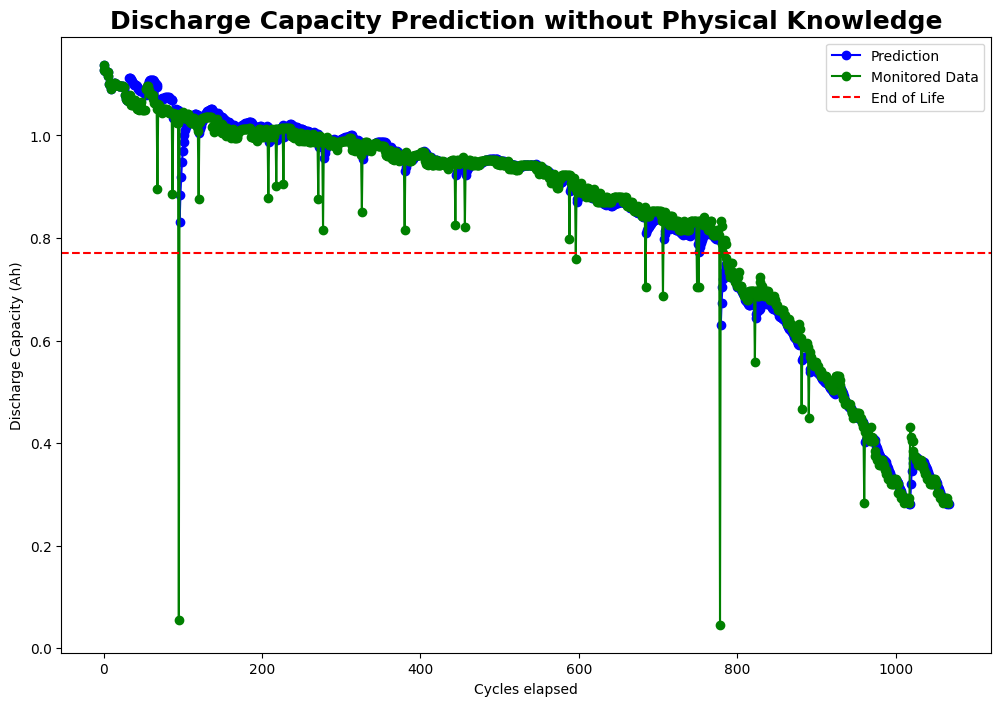

In [127]:
plt.figure(figsize = (12,8))

plt.plot(y_pred_future,linestyle='solid', marker='o', color='b', label='Prediction')
plt.plot(test,linestyle='solid', marker='o', color='g', label='Monitored Data')


plt.axhline(y = .7*1.1, color = 'r', linestyle = '--', label = 'End of Life')


plt.xlabel('Cycles elapsed')
plt.ylabel('Discharge Capacity (Ah)')

plt.title("Discharge Capacity Prediction without Physical Knowledge", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [67]:
test[31:36]

array([[1.06731647],
       [1.07783176],
       [1.07899952],
       [1.06766208],
       [1.06005087]])

In [68]:
y_pred_future[31:36]

array([[1.06731647],
       [1.11275711],
       [1.11240612],
       [1.11227378],
       [1.10954051]])

In [69]:
len(test_predictions)

1068

In [70]:
len(test)

1067

In [71]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred_future[:-1], test, squared=False)

0.04774088670736023

In [72]:
from keras import Sequential
from keras.layers import Dense, Masking, LSTM


from numpy.random import seed
seed(42)



opt = keras.optimizers.Adam()
callback = keras.callbacks.EarlyStopping(monitor='loss',patience =3)


model = Sequential()
model.add(LSTM(64,return_sequences=False))
model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(optimizer=opt, loss='mae', metrics=['mse', 'mae', 'mape', keras.metrics.RootMeanSquaredError(name='rmse')],run_eagerly = True)

In [73]:
model.fit(X1_,y1, epochs=30, verbose=1)

Epoch 1/30
25/25 [==============================] - 1s 23ms/step - loss: 0.2564 - mse: 0.1268 - mae: 0.2564 - mape: 38.8070 - rmse: 0.3561
Epoch 2/30
25/25 [==============================] - 1s 23ms/step - loss: 0.0397 - mse: 0.0027 - mae: 0.0397 - mape: 10.7799 - rmse: 0.0523
Epoch 3/30
25/25 [==============================] - 1s 23ms/step - loss: 0.0186 - mse: 7.2248e-04 - mae: 0.0186 - mape: 5.1777 - rmse: 0.0269
Epoch 4/30
25/25 [==============================] - 1s 23ms/step - loss: 0.0116 - mse: 2.3964e-04 - mae: 0.0116 - mape: 2.2649 - rmse: 0.0155
Epoch 5/30
25/25 [==============================] - 1s 23ms/step - loss: 0.0112 - mse: 2.1712e-04 - mae: 0.0112 - mape: 2.2002 - rmse: 0.0147
Epoch 6/30
25/25 [==============================] - 1s 23ms/step - loss: 0.0110 - mse: 2.2276e-04 - mae: 0.0110 - mape: 2.0840 - rmse: 0.0149
Epoch 7/30
25/25 [==============================] - 1s 23ms/step - loss: 0.0108 - mse: 2.0969e-04 - mae: 0.0108 - mape: 2.0036 - rmse: 0.0145
Epoch 8/30
2

In [74]:
model.fit(X2_,y2, epochs=30, verbose=1)

Epoch 1/30
26/26 [==============================] - 1s 23ms/step - loss: 0.0095 - mse: 1.8344e-04 - mae: 0.0095 - mape: 1.7662 - rmse: 0.0135
Epoch 2/30
26/26 [==============================] - 1s 23ms/step - loss: 0.0101 - mse: 1.9684e-04 - mae: 0.0101 - mape: 1.8433 - rmse: 0.0140
Epoch 3/30
26/26 [==============================] - 1s 23ms/step - loss: 0.0106 - mse: 2.1363e-04 - mae: 0.0106 - mape: 1.8917 - rmse: 0.0146
Epoch 4/30
26/26 [==============================] - 1s 23ms/step - loss: 0.0099 - mse: 1.9335e-04 - mae: 0.0099 - mape: 1.8242 - rmse: 0.0139
Epoch 5/30
26/26 [==============================] - 1s 23ms/step - loss: 0.0100 - mse: 1.9798e-04 - mae: 0.0100 - mape: 1.8087 - rmse: 0.0141
Epoch 6/30
26/26 [==============================] - 1s 23ms/step - loss: 0.0096 - mse: 1.9029e-04 - mae: 0.0096 - mape: 1.7289 - rmse: 0.0138
Epoch 7/30
26/26 [==============================] - 1s 23ms/step - loss: 0.0103 - mse: 2.0542e-04 - mae: 0.0103 - mape: 1.8387 - rmse: 0.0143
Epoch 

In [75]:
model.fit(X3_,y3, epochs=30, verbose=1)

Epoch 1/30
28/28 [==============================] - 1s 24ms/step - loss: 0.0090 - mse: 1.6749e-04 - mae: 0.0090 - mape: 1.3984 - rmse: 0.0129
Epoch 2/30
28/28 [==============================] - 1s 25ms/step - loss: 0.0088 - mse: 1.6033e-04 - mae: 0.0088 - mape: 1.3852 - rmse: 0.0127
Epoch 3/30
28/28 [==============================] - 1s 28ms/step - loss: 0.0079 - mse: 1.4588e-04 - mae: 0.0079 - mape: 1.2676 - rmse: 0.0121
Epoch 4/30
28/28 [==============================] - 1s 35ms/step - loss: 0.0082 - mse: 1.4854e-04 - mae: 0.0082 - mape: 1.3207 - rmse: 0.0122
Epoch 5/30
28/28 [==============================] - 1s 39ms/step - loss: 0.0079 - mse: 1.4045e-04 - mae: 0.0079 - mape: 1.2620 - rmse: 0.0119
Epoch 6/30
28/28 [==============================] - 1s 33ms/step - loss: 0.0078 - mse: 1.3567e-04 - mae: 0.0078 - mape: 1.2497 - rmse: 0.0116
Epoch 7/30
28/28 [==============================] - 1s 33ms/step - loss: 0.0095 - mse: 1.7428e-04 - mae: 0.0095 - mape: 1.4931 - rmse: 0.0132
Epoch 

In [76]:
test = data_all['CS2_38']
test = test.dropna()

In [77]:
test = test['discharging capacity']
test = pd.DataFrame(test)
test = ss.fit_transform(test)

In [78]:
test_predictions_huber = []

test_predictions_huber.extend(test[:n_input])

for i in range(len(test)-n_input+1):
    
    # get the prediction value for the first batch
    
    dummy = test[i:i+n_input].reshape((1, n_input, 1))
    # use the prediction to update the batch and remove the first value
    current_batch = (dummy)
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_huber.append(current_pred) 



1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


In [79]:
test = ss.inverse_transform(test)
y_pred_future_huber = ss.inverse_transform(test_predictions_huber)

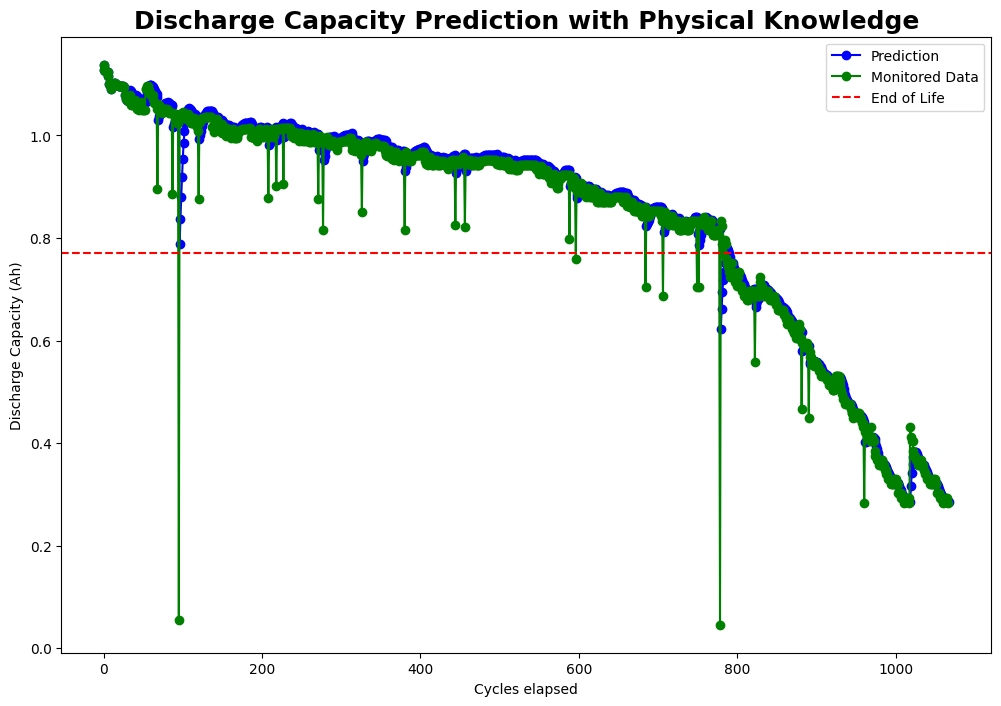

In [125]:
plt.figure(figsize = (12,8))

plt.plot(y_pred_future_huber,linestyle='solid', marker='o', color='b', label='Prediction')
plt.plot(test,linestyle='solid', marker='o', color='g', label='Monitored Data')


plt.axhline(y = .7*1.1, color = 'r', linestyle = '--', label = 'End of Life')


plt.xlabel('Cycles elapsed')
plt.ylabel('Discharge Capacity (Ah)')


plt.title("Discharge Capacity Prediction with Physical Knowledge", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [81]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred_future_huber[:-1], test, squared=False)

0.04838064279601584

In [82]:
mse_custom = []
for k in range(len(test)):
    mse_custom.append(mean_squared_error(y_pred_future[k],test[k]))
    
mse_huber = []
for k in range(len(test)):
    mse_huber.append(mean_squared_error(y_pred_future_huber[k],test[k]))

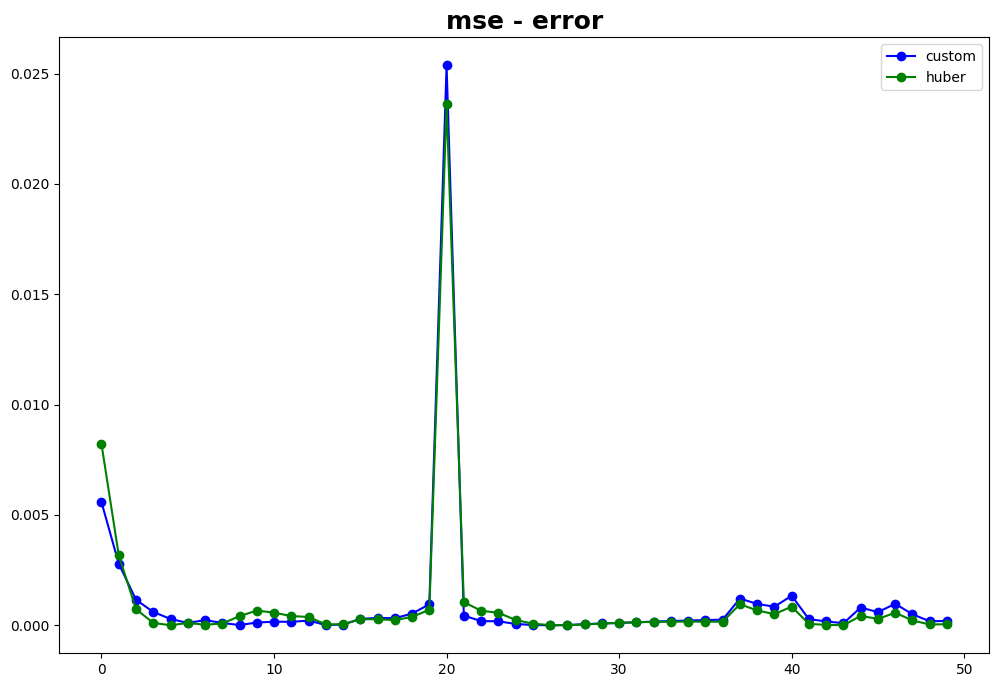

In [83]:
plt.figure(figsize = (12,8))

plt.plot(mse_custom[100:150],linestyle='solid', marker='o', color='b', label='custom')
plt.plot(mse_huber[100:150],linestyle='solid', marker='o', color='g', label='huber')






plt.title("mse - error", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

### RUL

In [84]:
from utility import drop_outlier_sw

name = battery_list[1]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t1 = battery['cycle']
y1 = battery['discharging capacity']


rolling_window = 20
idx = drop_outlier_sw(y1, rolling_window)

t1 = np.array(t1[idx])
y1 = np.array(y1[idx])



name = battery_list[2]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t2 = battery['cycle']
y2 = battery['discharging capacity']

rolling_window = 20
idx = drop_outlier_sw(y2, rolling_window)

t2 = np.array(t2[idx])
y2 = np.array(y2[idx])



name = battery_list[0]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t3 = battery['cycle']
y3 = battery['discharging capacity']

rolling_window = 20
idx = drop_outlier_sw(y3, rolling_window)

t3 = np.array(t3[idx])
y3 = np.array(y3[idx])

In [85]:
true_ttf1, idx_ttf1 = cal_ttf(t1, y1, .7*1.1)
true_ttf2, idx_ttf2 = cal_ttf(t2, y2, .7*1.1)
true_ttf3, idx_ttf3 = cal_ttf(t3, y3, .7*1.1)


In [86]:
initial_rul1 = true_ttf1 - 32
initial_rul2 = true_ttf2 - 32
initial_rul3 = true_ttf3 - 32


In [87]:
### calculate RUL on sliding window

window_size = n_input = 32

X1 = []
Y1 = []

k=0
j=0

window_cycle = initial_rul1
while window_cycle > 0:
    window_cycle = initial_rul1-k
    window = np.array(y1[j:j+window_size])
    k+=1
    j+=1
    X1.append(window)
    Y1.append(window_cycle)
    
X1 = np.array(X1)
Y1 = np.array(Y1)


##############
X2 = []
Y2 = []

k=0
j=0

window_cycle = initial_rul2
while window_cycle > 0:
    window_cycle = initial_rul2-k
    window = np.array(y2[j:j+window_size])
    k+=1
    j+=1
    X2.append(window)
    Y2.append(window_cycle)
    
X2 = np.array(X2)
Y2 = np.array(Y2)

#############

X3 = []
Y3 = []

k=0
j=0

window_cycle = initial_rul3
while window_cycle > 0:
    window_cycle = initial_rul3-k
    window = np.array(y3[j:j+window_size])
    k+=1
    j+=1
    X3.append(window)
    Y3.append(window_cycle)
    
X3 = np.array(X3)
Y3 = np.array(Y3)



In [88]:
from sklearn.preprocessing import MinMaxScaler

ss1 = MinMaxScaler()
ss2 = MinMaxScaler()
ss3 = MinMaxScaler()

Y1 = pd.DataFrame(Y1)
Y1 = ss1.fit_transform(Y1)

Y2 = pd.DataFrame(Y2)
Y2 = ss1.fit_transform(Y2)

Y3 = pd.DataFrame(Y3)
Y3 = ss1.fit_transform(Y3)

In [89]:
X1 = X1[:608]
Y1 = Y1[:608]

X1 = X1.reshape((X1.shape[0], X1.shape[1], 1))
Y1 = Y1.reshape(Y1.shape[0],1)

X2 = X2[:608]
Y2 = Y2[:608]
X2 = X2.reshape((X2.shape[0], X2.shape[1], 1))
Y2 = Y2.reshape(Y2.shape[0],1)

X3 = X3[:768]
Y3 = Y3[:768]
X3 = X3.reshape((X3.shape[0], X3.shape[1], 1))
Y3 = Y3.reshape(Y3.shape[0],1)

    val = y_pred - m
    m = y_pred
    print(m)
    print(val+ tf.math.abs(y_true-y_pred))

In [90]:
len(X3)

639

In [91]:
m = 0

def loss(y_true,y_pred):
    global m 
    val = y_pred - m
    m = y_pred
    print((val))
    print(tensorflow.executing_eagerly())
    return (val) + tensorflow.math.abs((y_true-y_pred))

In [92]:
def huber_fn(y_true, y_pred):
    global m 
    val = y_pred - m
    m = y_true
    error = y_true - y_pred
    is_small_error = tensorflow.abs(error) < 1 + val
    squared_loss = tensorflow.square(error) / 2 + tensorflow.square(val)
    linear_loss  = tensorflow.abs(error) - 0.5
    print(tensorflow.executing_eagerly())
    return tensorflow.where(is_small_error, squared_loss, linear_loss)

In [93]:
def penalty(y_true,y_pred):
    a = 15
    b = 10
    err = y_true-y_pred
    is_negative_error = err < 0
    print(err)
    print(tensorflow.executing_eagerly())
    under = tensorflow.math.exp((-err/a))-1
    over = tensorflow.math.exp((err/b))-1
    print(over)
    print(tensorflow.executing_eagerly())
    return tf.where(is_negative_error, under, over)

In [94]:
from keras import Sequential
from keras.layers import Dense, Masking, LSTM, Dropout, BatchNormalization, Bidirectional


from numpy.random import seed
seed(42)



opt = tensorflow.keras.optimizers.Adam()
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss',patience =3)


model_rul = Sequential()
model_rul.add((LSTM(16,return_sequences=False)))
model_rul.add(Dense(8, activation='relu'))
model_rul.add(Dense(1, activation='relu'))

model_rul.compile(optimizer=opt, loss='mse', metrics=['mse', 'mae', 'mape', tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')],run_eagerly = True)

In [95]:
model_rul.fit(X1,Y1, epochs=20, verbose=2)

Epoch 1/20
19/19 - 1s - loss: 0.1706 - mse: 0.1706 - mae: 0.3360 - mape: 66.3996 - rmse: 0.4131 - 845ms/epoch - 44ms/step
Epoch 2/20
19/19 - 1s - loss: 0.0702 - mse: 0.0702 - mae: 0.2254 - mape: 88.4801 - rmse: 0.2650 - 519ms/epoch - 27ms/step
Epoch 3/20
19/19 - 1s - loss: 0.0643 - mse: 0.0643 - mae: 0.2206 - mape: 96.0507 - rmse: 0.2536 - 522ms/epoch - 27ms/step
Epoch 4/20
19/19 - 1s - loss: 0.0614 - mse: 0.0614 - mae: 0.2151 - mape: 88.9965 - rmse: 0.2479 - 514ms/epoch - 27ms/step
Epoch 5/20
19/19 - 1s - loss: 0.0598 - mse: 0.0598 - mae: 0.2127 - mape: 90.6684 - rmse: 0.2445 - 524ms/epoch - 28ms/step
Epoch 6/20
19/19 - 1s - loss: 0.0580 - mse: 0.0580 - mae: 0.2094 - mape: 86.3765 - rmse: 0.2409 - 520ms/epoch - 27ms/step
Epoch 7/20
19/19 - 1s - loss: 0.0555 - mse: 0.0555 - mae: 0.2053 - mape: 89.0137 - rmse: 0.2356 - 516ms/epoch - 27ms/step
Epoch 8/20
19/19 - 1s - loss: 0.0513 - mse: 0.0513 - mae: 0.1979 - mape: 83.0588 - rmse: 0.2266 - 519ms/epoch - 27ms/step
Epoch 9/20
19/19 - 1s - 

In [96]:
model_rul.fit(X2,Y2, epochs=20, verbose=2)

Epoch 1/20
19/19 - 1s - loss: 0.0066 - mse: 0.0066 - mae: 0.0675 - mape: 14.3734 - rmse: 0.0810 - 525ms/epoch - 28ms/step
Epoch 2/20
19/19 - 1s - loss: 0.0021 - mse: 0.0021 - mae: 0.0350 - mape: 6.5348 - rmse: 0.0454 - 521ms/epoch - 27ms/step
Epoch 3/20
19/19 - 1s - loss: 0.0016 - mse: 0.0016 - mae: 0.0313 - mape: 5.9061 - rmse: 0.0403 - 518ms/epoch - 27ms/step
Epoch 4/20
19/19 - 1s - loss: 0.0015 - mse: 0.0015 - mae: 0.0296 - mape: 5.3977 - rmse: 0.0381 - 522ms/epoch - 27ms/step
Epoch 5/20
19/19 - 1s - loss: 0.0013 - mse: 0.0013 - mae: 0.0283 - mape: 5.1823 - rmse: 0.0366 - 521ms/epoch - 27ms/step
Epoch 6/20
19/19 - 1s - loss: 0.0014 - mse: 0.0014 - mae: 0.0278 - mape: 5.2483 - rmse: 0.0368 - 515ms/epoch - 27ms/step
Epoch 7/20
19/19 - 1s - loss: 0.0014 - mse: 0.0014 - mae: 0.0283 - mape: 5.2579 - rmse: 0.0372 - 517ms/epoch - 27ms/step
Epoch 8/20
19/19 - 1s - loss: 0.0015 - mse: 0.0015 - mae: 0.0289 - mape: 5.3444 - rmse: 0.0392 - 521ms/epoch - 27ms/step
Epoch 9/20
19/19 - 1s - loss: 0

In [97]:
model_rul.fit(X3,Y3, epochs=20, verbose=2)

Epoch 1/20
20/20 - 1s - loss: 0.0083 - mse: 0.0083 - mae: 0.0728 - mape: 120217.8516 - rmse: 0.0912 - 730ms/epoch - 36ms/step
Epoch 2/20
20/20 - 1s - loss: 0.0050 - mse: 0.0050 - mae: 0.0541 - mape: 115267.6562 - rmse: 0.0708 - 552ms/epoch - 28ms/step
Epoch 3/20
20/20 - 1s - loss: 0.0056 - mse: 0.0056 - mae: 0.0574 - mape: 101255.7969 - rmse: 0.0749 - 549ms/epoch - 27ms/step
Epoch 4/20
20/20 - 1s - loss: 0.0037 - mse: 0.0037 - mae: 0.0459 - mape: 91251.7344 - rmse: 0.0605 - 545ms/epoch - 27ms/step
Epoch 5/20
20/20 - 1s - loss: 0.0038 - mse: 0.0038 - mae: 0.0460 - mape: 86257.6875 - rmse: 0.0618 - 552ms/epoch - 28ms/step
Epoch 6/20
20/20 - 1s - loss: 0.0043 - mse: 0.0043 - mae: 0.0495 - mape: 82127.7031 - rmse: 0.0653 - 549ms/epoch - 27ms/step
Epoch 7/20
20/20 - 1s - loss: 0.0055 - mse: 0.0055 - mae: 0.0559 - mape: 78056.6250 - rmse: 0.0743 - 549ms/epoch - 27ms/step
Epoch 8/20
20/20 - 1s - loss: 0.0043 - mse: 0.0043 - mae: 0.0489 - mape: 74520.0469 - rmse: 0.0652 - 556ms/epoch - 28ms/st

In [98]:
y_pred_future = np.array(y_pred_future)
test = np.array(test)

In [99]:
cycle = np.arange(1,len(y_pred_future))

In [100]:
true_test, idx_test = cal_ttf(cycle, y_pred_future,  .7*1.1)

In [101]:
true_test

782

In [102]:

rul_test = true_test - 32
rul_test

y_test = []
k=0

window_cycle = rul_test
while window_cycle > 0:
    window_cycle = rul_test-k
    y_test.append(window_cycle)
    k+=1
    
y_test = np.array(y_test)


In [103]:
rul_predictions = []

k=0
j=0

first_eval_batch = y_pred_future[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, 1))

window_cycle = rul_test
while window_cycle >= 0:
    window_cycle = rul_test-k
    window = np.array(y_pred_future[j:j+32])
    current_batch = window.reshape((1, n_input, 1))
    current_pred = model_rul.predict(current_batch)[0]
    rul_predictions.append(current_pred) 
    j+=1
    k+=1
    

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


In [104]:
rul_pred = ss1.inverse_transform(rul_predictions)

In [105]:
rul_predictions

[array([0.9974307], dtype=float32),
 array([0.99857664], dtype=float32),
 array([0.99888384], dtype=float32),
 array([0.99907136], dtype=float32),
 array([0.99889374], dtype=float32),
 array([0.9983946], dtype=float32),
 array([0.99771655], dtype=float32),
 array([0.99715126], dtype=float32),
 array([0.9969257], dtype=float32),
 array([0.99682736], dtype=float32),
 array([0.996786], dtype=float32),
 array([0.99667525], dtype=float32),
 array([0.9959744], dtype=float32),
 array([0.99504507], dtype=float32),
 array([0.99387014], dtype=float32),
 array([0.9926137], dtype=float32),
 array([0.9916793], dtype=float32),
 array([0.9909606], dtype=float32),
 array([0.9900911], dtype=float32),
 array([0.98915863], dtype=float32),
 array([0.98820627], dtype=float32),
 array([0.9872681], dtype=float32),
 array([0.98637116], dtype=float32),
 array([0.9864458], dtype=float32),
 array([0.9870688], dtype=float32),
 array([0.98823655], dtype=float32),
 array([0.98980284], dtype=float32),
 array([0.9914

plt.figure(figsize = (12,8))

plt.plot(rul_pred,linestyle='--', marker='o', color='b', label='Predicted RUL')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')


plt.title("Comparison - RNN Outlier removed", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [106]:
y_pred_future_huber = np.array(y_pred_future_huber)
test = np.array(test)
cycle = np.arange(1,len(y_pred_future_huber))
true_test, idx_test = cal_ttf(cycle, y_pred_future_huber,  .7*1.1)

In [107]:
true_test

782

In [108]:
rul_predictions_custom = []

k=0
j=0

first_eval_batch = y_pred_future_huber[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, 1))

window_cycle = rul_test
while window_cycle >= 0:
    window_cycle = rul_test-k
    window = np.array(y_pred_future_huber[j:j+32])
    current_batch = window.reshape((1, n_input, 1))
    current_pred = model_rul.predict(current_batch)[0]
    rul_predictions_custom.append(current_pred) 
    j+=1
    k+=1
    

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 17ms/step


In [109]:
rul_pred_custom = ss1.inverse_transform(rul_predictions_custom)

In [110]:
rul_predictions_custom

[array([0.9974307], dtype=float32),
 array([0.9959725], dtype=float32),
 array([0.99446285], dtype=float32),
 array([0.9930475], dtype=float32),
 array([0.9914366], dtype=float32),
 array([0.9896202], dtype=float32),
 array([0.98772776], dtype=float32),
 array([0.9860462], dtype=float32),
 array([0.98480403], dtype=float32),
 array([0.9838158], dtype=float32),
 array([0.98299885], dtype=float32),
 array([0.9821619], dtype=float32),
 array([0.9807151], dtype=float32),
 array([0.97901726], dtype=float32),
 array([0.97703904], dtype=float32),
 array([0.97494555], dtype=float32),
 array([0.97319746], dtype=float32),
 array([0.97168964], dtype=float32),
 array([0.96998], dtype=float32),
 array([0.9681407], dtype=float32),
 array([0.96620893], dtype=float32),
 array([0.96422416], dtype=float32),
 array([0.96222466], dtype=float32),
 array([0.9613178], dtype=float32),
 array([0.9610396], dtype=float32),
 array([0.961413], dtype=float32),
 array([0.96228284], dtype=float32),
 array([0.96330583

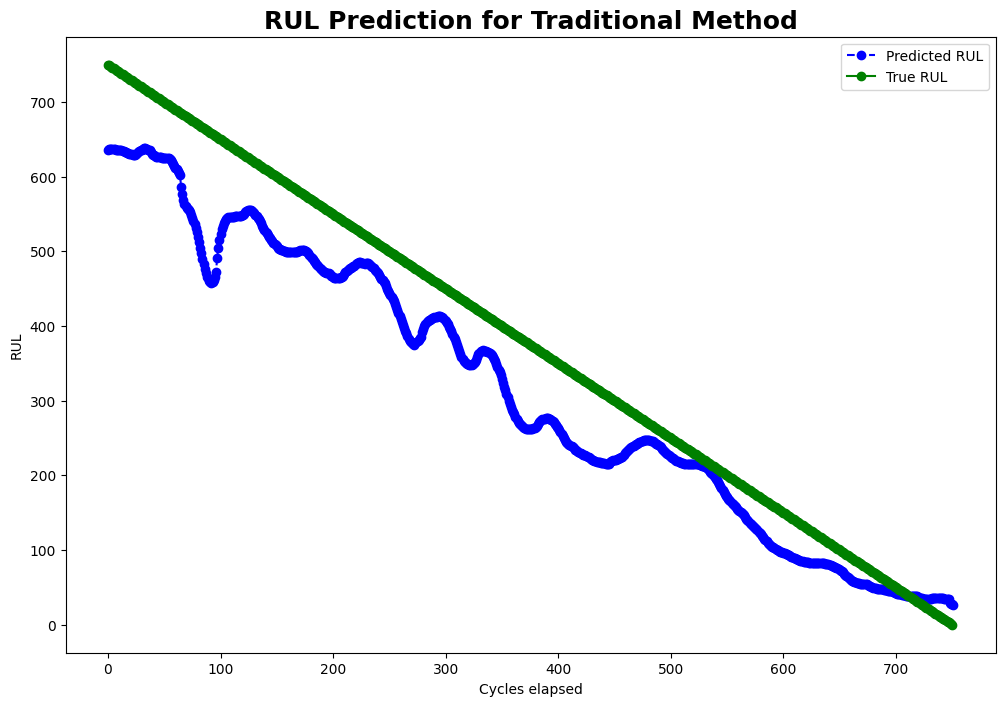

In [111]:
plt.figure(figsize = (12,8))

plt.plot(rul_pred,linestyle='--', marker='o', color='b', label='Predicted RUL')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')

plt.xlabel('Cycles elapsed')
plt.ylabel('RUL')
plt.title("RUL Prediction for Traditional Method", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [112]:
rul_predictions_test = []

k=0
j=0

first_eval_batch = test[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, 1))

window_cycle = rul_test
while window_cycle >= 0:
    window_cycle = rul_test-k
    window = np.array(test[j:j+32])
    current_batch = window.reshape((1, n_input, 1))
    current_pred = model_rul.predict(current_batch)[0]
    rul_predictions_test.append(current_pred) 
    j+=1
    k+=1
    

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


In [113]:
rul_predictions_test = ss1.inverse_transform(rul_predictions_test)

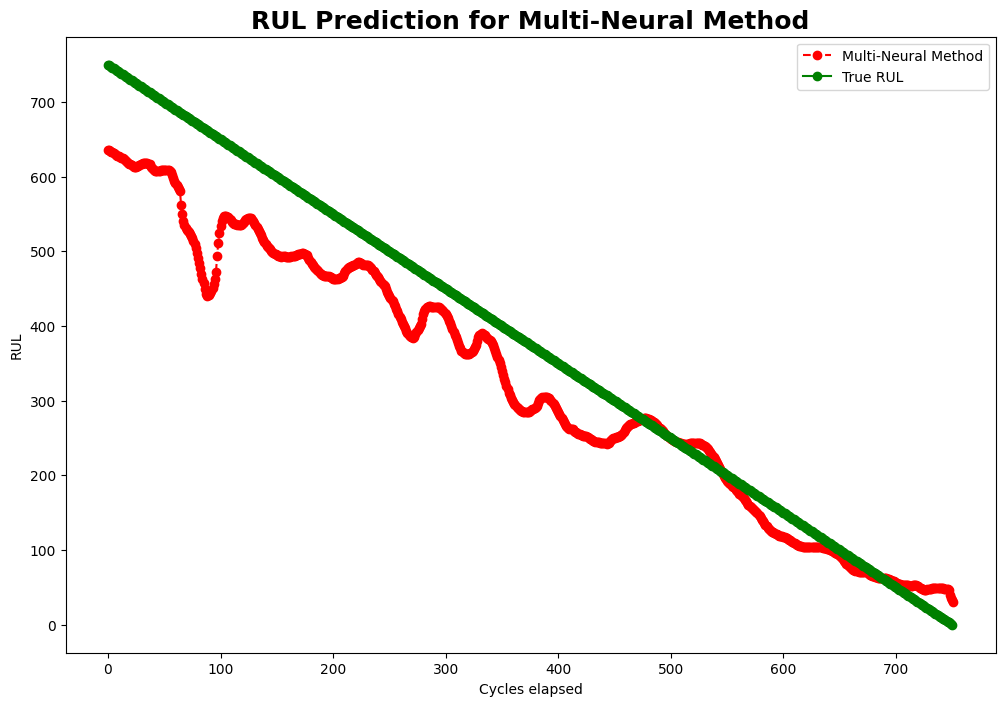

In [114]:
plt.figure(figsize = (12,8))

plt.plot(rul_pred_custom,linestyle='--', marker='o', color='r', label='Multi-Neural Method')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')
plt.xlabel('Cycles elapsed')
plt.ylabel('RUL')
plt.title("RUL Prediction for Multi-Neural Method", fontsize=18, fontweight="bold")
plt.legend()


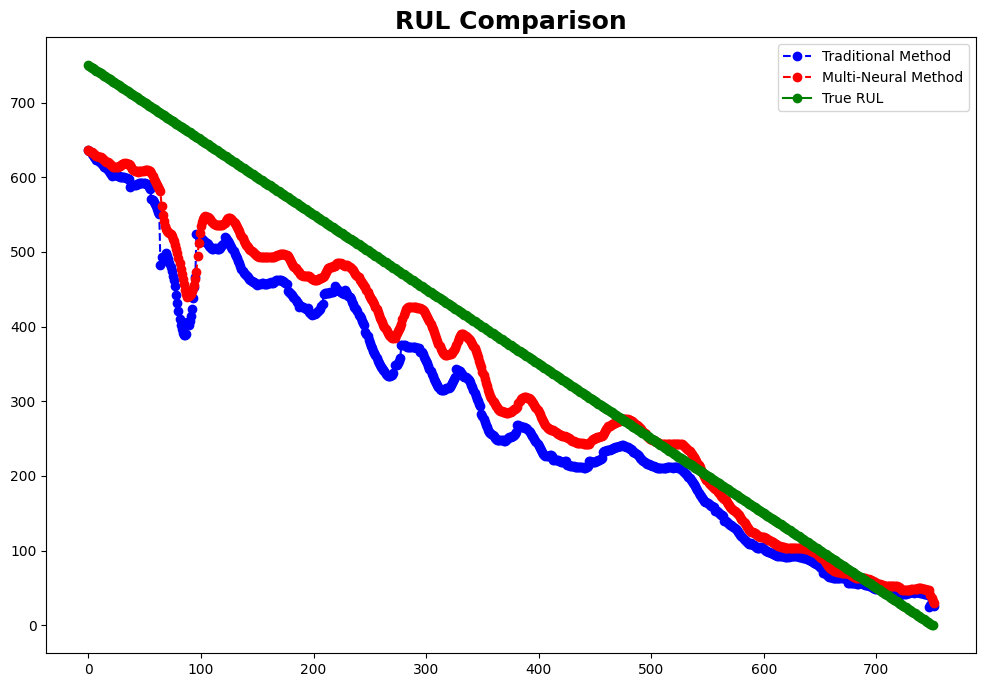

In [115]:
plt.figure(figsize = (12,8))

plt.plot(rul_predictions_test,linestyle='--', marker='o', color='b', label='Traditional Method')
plt.plot(rul_pred_custom,linestyle='--', marker='o', color='r', label='Multi-Neural Method')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')
plt.title("RUL Comparison", fontsize=18, fontweight="bold")
plt.legend()


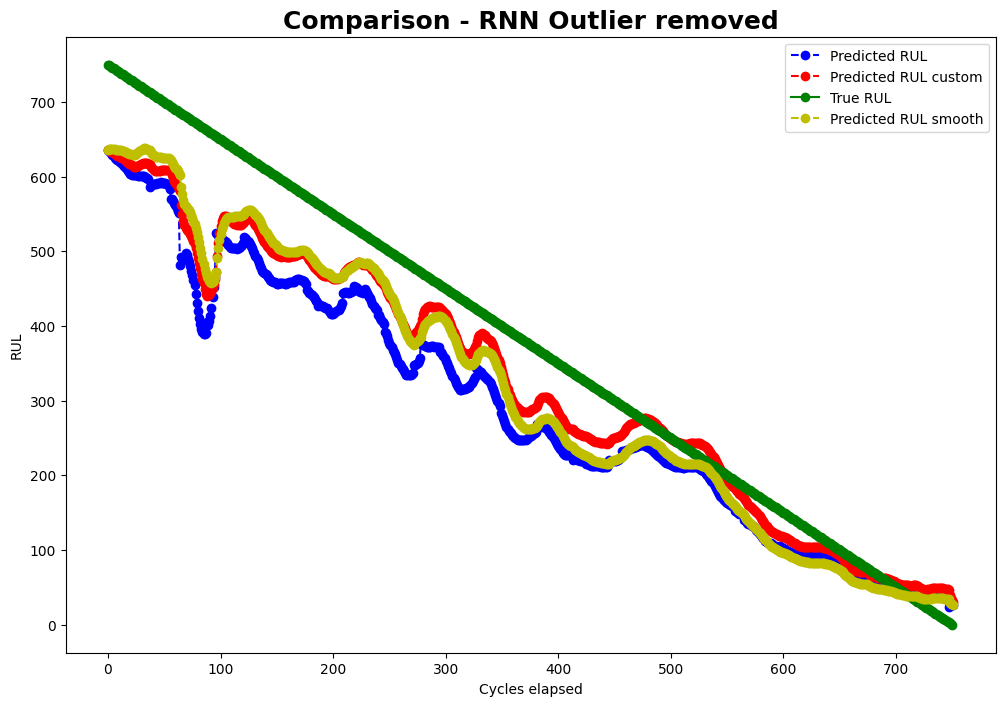

In [116]:
plt.figure(figsize = (12,8))

plt.plot(rul_predictions_test,linestyle='--', marker='o', color='b', label='Predicted RUL')
plt.plot(rul_pred_custom,linestyle='--', marker='o', color='r', label='Predicted RUL custom')
plt.plot(y_test,linestyle='solid', marker='o', color='g', label='True RUL')
plt.xlabel('Cycles elapsed')
plt.ylabel('RUL')
plt.plot(rul_pred,linestyle='--', marker='o', color='y', label='Predicted RUL smooth')


plt.title("Comparison - RNN Outlier removed", fontsize=18, fontweight="bold")
plt.legend()

plt.show()

In [117]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, rul_predictions_test[:-1], squared=False)


101.09603988128937

In [118]:
### NEURAL FILTERED

mean_squared_error(y_test, rul_pred[:-1], squared=False)

73.47421593435575

In [119]:



%load_ext jupyternotify



<IPython.core.display.Javascript object>

In [120]:
%%notify

### NEURAL FILTERED custom loss


mean_squared_error(y_test, rul_pred_custom[:-1], squared=False)

71.83119947830562

<IPython.core.display.Javascript object>